In [33]:
# Command to reload all modules before executing the code
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# ML libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Utils
import os
import sys
from collections import defaultdict
from tqdm import tqdm
import warnings
from typing import List, Dict, Any, Tuple, Union, Optional, Callable, TypeVar
# Project modules
pass

warnings.filterwarnings('ignore')

# Comparison of the distributions in train vs in test

In this notebook, we unsure the train distribution match the test distribution. We will plot the train and test distribution of each metric averaged side by side, and also put in evidence the metrics whose train vs test distribution is most different according to our criteria.

## Team features

In [35]:
from src.data_loading import load_dataframe_teamfeatures
df_teamfeatures_train = load_dataframe_teamfeatures('train')
df_teamfeatures_test = load_dataframe_teamfeatures('test')

In [36]:
from src.data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference, loss_name_to_loss_fn


# This is for unsuring the compute_distribution_difference works as expected

n_value_max = 100
n_data = 1000
K = 5
n_monte_carlo = 10

print("Experience 1 : distribution difference between data coming from the same distribution")
for _ in range(K):
        serie1 = np.random.randint(0, n_value_max+1, n_data)
        serie2 = np.random.randint(0, n_value_max+1, n_data // 2)

        loss_name_to_loss_values_experimental = compute_distribution_difference(
                feature_serie1=pd.Series(serie1),
                feature_serie2=pd.Series(serie2),
                n_monte_carlo=n_monte_carlo,
                n_value_max=n_value_max,
                normalization_method='mc_estimated_loss',
                )
        print(loss_name_to_loss_values_experimental["l1_loss"]["loss_value_normalized"])
        
        
print("Experience 2 : distribution difference between data coming from different distributions")
for _ in range(K):
        serie1 = np.random.randint(0, n_value_max+1, n_data)
        serie2 = np.random.randint(0, (n_value_max+1) // 2, n_data)

        loss_name_to_loss_values_experimental = compute_distribution_difference(
                feature_serie1=pd.Series(serie1),
                feature_serie2=pd.Series(serie2),
                n_monte_carlo=n_monte_carlo,
                n_value_max=n_value_max,
                normalization_method='mc_estimated_loss',
                )
        print(loss_name_to_loss_values_experimental["l1_loss"]["loss_value_normalized"])
        
print("Experience 3 : distribution difference between data coming from non independent distributions")
for _ in range(K):
        serie1 = np.random.randint(0, n_value_max+1, n_data)
        serie2 = np.random.randint(0, n_value_max+1, n_data)
        serie2[:n_data//2] = serie1[:n_data//2]

        loss_name_to_loss_values_experimental = compute_distribution_difference(
                feature_serie1=pd.Series(serie1),
                feature_serie2=pd.Series(serie2),
                n_monte_carlo=n_monte_carlo,
                n_value_max=n_value_max,
                normalization_method='mc_estimated_loss',
                )
        print(loss_name_to_loss_values_experimental["l1_loss"]["loss_value_normalized"])

Experience 1 : distribution difference between data coming from the same distribution
0.9883026975411262
1.1412908048840629
1.127379209370363
1.0051425899952722
0.8457943925233199
Experience 2 : distribution difference between data coming from different distributions
3.499165275458836
3.381127042347196
3.334458319270757
3.352483947279233
3.3487450462348907
Experience 3 : distribution difference between data coming from non independent distributions
0.6604042129233851
0.649798734905076
0.61616732617294
0.7920792079207404
0.7507941091538641


We plot the top 10 metrics season averaged distributions for train in test, in terms of difference between the two distributions.

Missing season_average for HOME_ID
Missing season_average for HOME_LEAGUE
Missing season_average for HOME_TEAM_NAME
Missing season_average for AWAY_ID
Missing season_average for AWAY_LEAGUE
Missing season_average for AWAY_TEAM_NAME
AWAY_TEAM_SUBSTITUTIONS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 7.2934761828679 (loss = l1_loss)


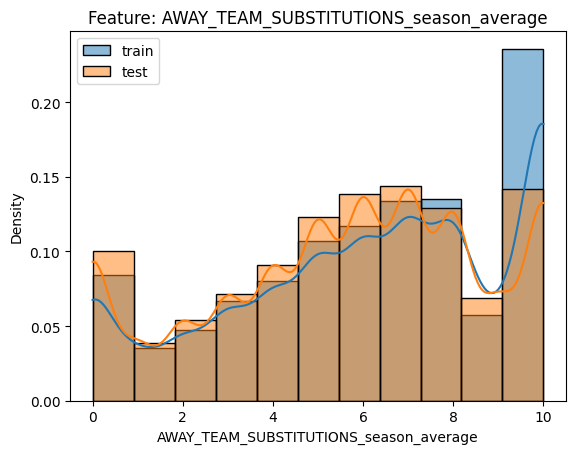

HOME_TEAM_SUBSTITUTIONS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.9316295379746755 (loss = l1_loss)


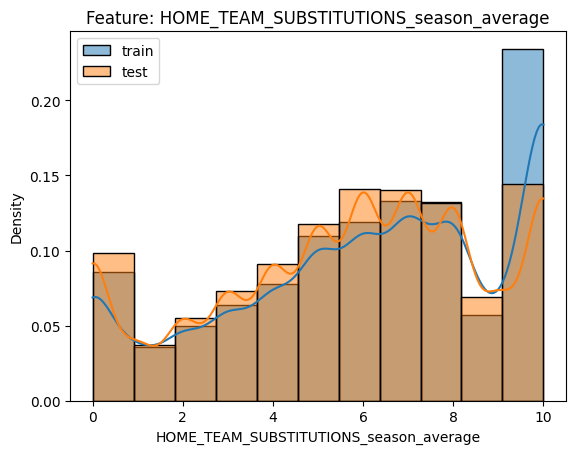

AWAY_TEAM_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.504091117500825 (loss = l1_loss)


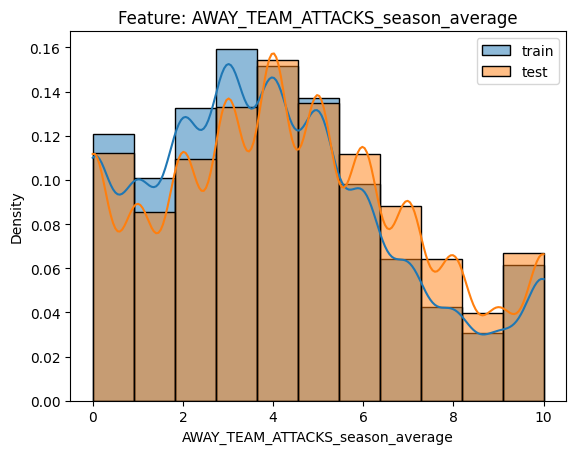

HOME_TEAM_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.338946568821388 (loss = l1_loss)


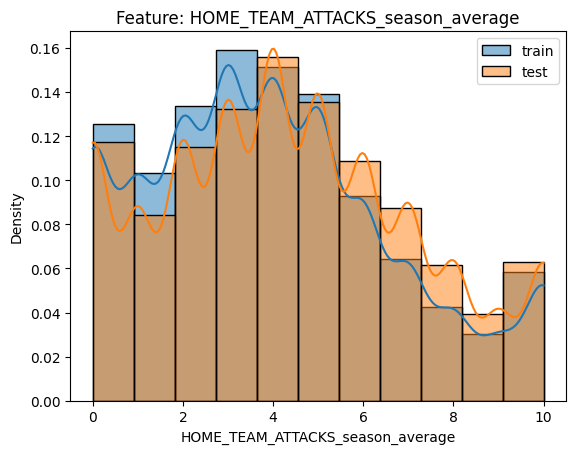

HOME_TEAM_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.951984703350647 (loss = l1_loss)


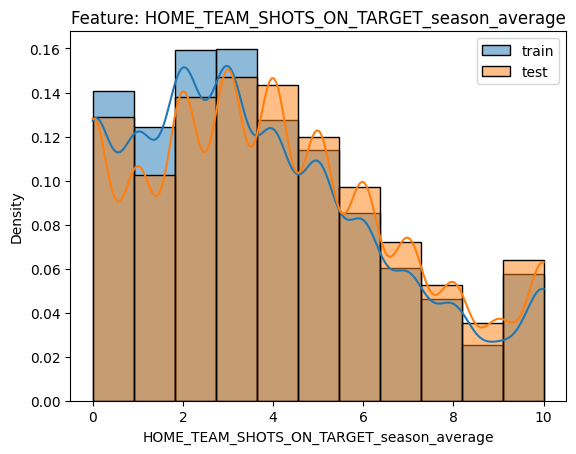

AWAY_TEAM_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.763850004201296 (loss = l1_loss)


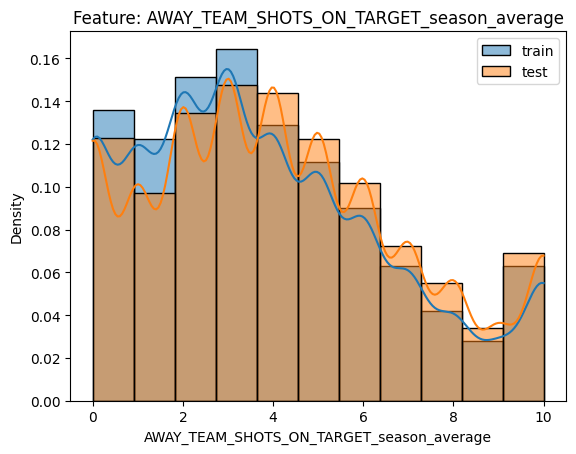

AWAY_TEAM_INJURIES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.8914347203155084 (loss = l1_loss)


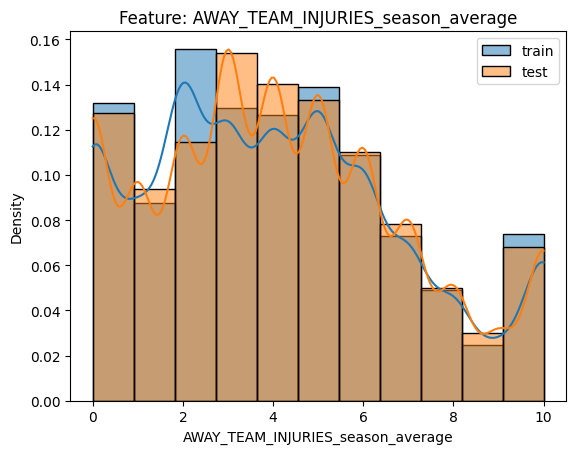

AWAY_TEAM_DANGEROUS_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.871659723281438 (loss = l1_loss)


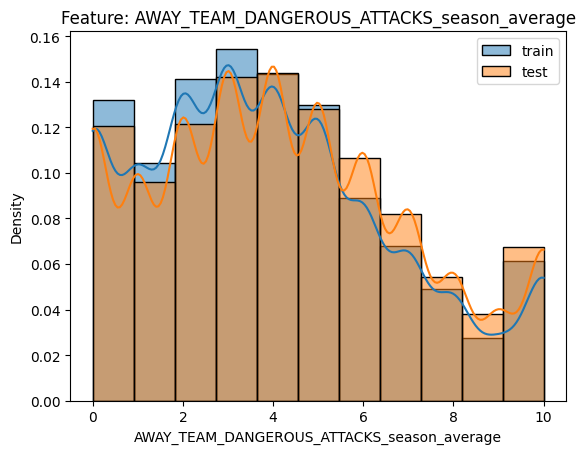

HOME_TEAM_GAME_WON_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.7043314071247693 (loss = l1_loss)


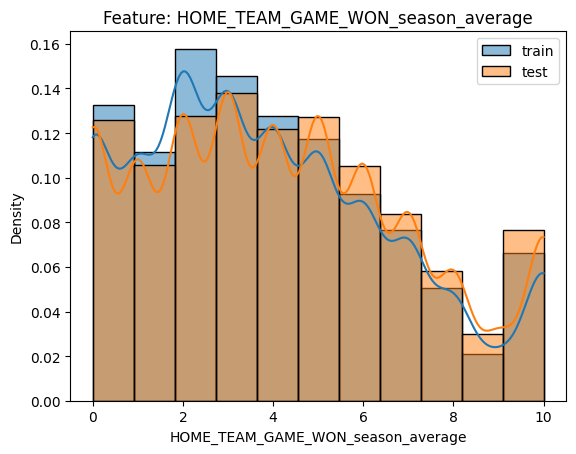

AWAY_TEAM_GAME_WON_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.6416128777091608 (loss = l1_loss)


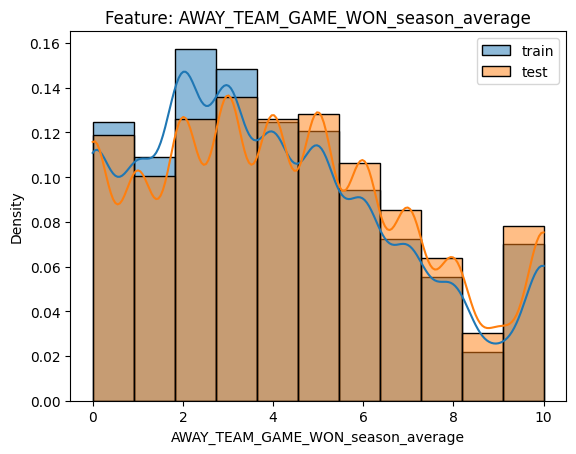

In [37]:
from src.data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference, loss_name_to_loss_fn

column_names_to_fn_names = get_metrics_names_to_fn_names(df_teamfeatures_train)
metric_names_to_loss_name_to_loss_values : Dict[str, Dict[str, float]] = {}
metric_names_to_loss_name_to_loss_values_train_1st_half_vs_2nd_half : Dict[str, Dict[str, float]] = {}
metric_names_to_loss_name_to_loss_values_test_1st_half_vs_2nd_half : Dict[str, Dict[str, float]] = {}
for metric_name, list_fn_names in column_names_to_fn_names.items():
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    column_name = f"{metric_name}_season_average"
    serie_train = df_teamfeatures_train[column_name]
    serie_train_shuffled = serie_train.sample(frac=1).reset_index(drop=True)
    serie_test = df_teamfeatures_test[column_name]
    serie_test_shuffled = serie_test.sample(frac=1).reset_index(drop=True)
    # Compute the distribution difference
    column_name = f"{metric_name}_season_average"
    metric_names_to_loss_name_to_loss_values[column_name] = compute_distribution_difference(
        feature_serie1=serie_train,
        feature_serie2=serie_test,
        n_monte_carlo=n_monte_carlo,
        n_value_max=10,
        normalization_method='mc_estimated_loss',
        )
    metric_names_to_loss_name_to_loss_values_train_1st_half_vs_2nd_half[column_name] = compute_distribution_difference(
        feature_serie1=serie_train_shuffled[:len(serie_train)//2],
        feature_serie2=serie_train_shuffled[len(serie_train)//2:],
        n_monte_carlo=n_monte_carlo,
        n_value_max=10,
        normalization_method='mc_estimated_loss',
        )
    metric_names_to_loss_name_to_loss_values_test_1st_half_vs_2nd_half[column_name] = compute_distribution_difference(
        feature_serie1=serie_test_shuffled[:len(serie_test)//2],
        feature_serie2=serie_test_shuffled[len(serie_test)//2:],
        n_monte_carlo=n_monte_carlo,
        n_value_max=10,
        normalization_method='mc_estimated_loss',
        )

# Print top differences
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']
n_top_metrics_to_plot = 10

for column_name, loss_name_to_loss_values in sorted(metric_names_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=True)[:n_top_metrics_to_plot]:
    print(f"{column_name} train-distribution vs test-distribution difference ({LOSS_STATISTIC}) : {loss_name_to_loss_values[LOSS_NAME][LOSS_STATISTIC]} (loss = {LOSS_NAME})")
    fig, ax = plt.subplots()
    ax.set_title(f"Feature: {column_name}")
    sns.histplot(df_teamfeatures_train[column_name], kde=True, label="train", stat='density', bins=11)
    sns.histplot(df_teamfeatures_test[column_name], kde=True, label="test", stat='density', bins=11)
    plt.legend()
    plt.show()

We plot here the distribution of those differences.

As we can see, if LOSS_STATISTIC = 'loss_value_normalized', a lot of metrics have a notably superior to 1 normalized difference, which means that the train and test distributions are notably different.

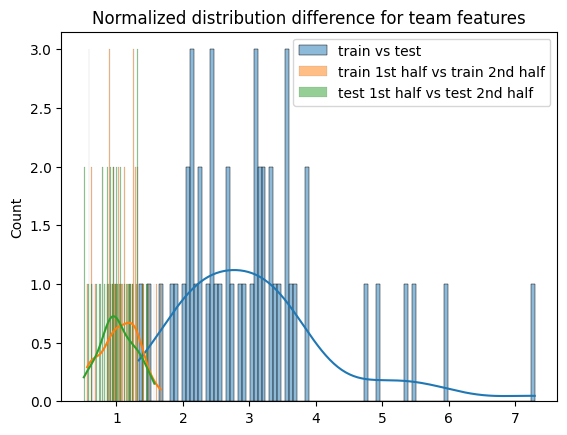

In [38]:
LOSS_NAME = 'l1_loss'
LOSS_STATISTIC = 'loss_value_normalized'

fig, ax = plt.subplots()
ax.set_title(f"Normalized distribution difference for team features")

# Histogram of the distribution of the normalized losses
loss_value_normalized_values_train_vs_test = list(metric_names_to_loss_name_to_loss_values.values())
loss_value_normalized_values_train_vs_test = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_train_vs_test]
sns.histplot(loss_value_normalized_values_train_vs_test, kde=True, label="train vs test", bins=100)

# Histogram of the distribution of the typical losses between train feature distribution first half and second half
loss_value_normalized_values_train_1st_half_vs_2nd_half = list(metric_names_to_loss_name_to_loss_values_train_1st_half_vs_2nd_half.values())
loss_value_normalized_values_train_1st_half_vs_2nd_half = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_train_1st_half_vs_2nd_half]
sns.histplot(loss_value_normalized_values_train_1st_half_vs_2nd_half, kde=True, label="train 1st half vs train 2nd half", bins=100)

# Histogram of the distribution of the typical losses between test feature distribution first half and second half
loss_value_normalized_values_test_1st_half_vs_2nd_half = list(metric_names_to_loss_name_to_loss_values_test_1st_half_vs_2nd_half.values())
loss_value_normalized_values_test_1st_half_vs_2nd_half = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_test_1st_half_vs_2nd_half]
sns.histplot(loss_value_normalized_values_test_1st_half_vs_2nd_half, kde=True, label="test 1st half vs test 2nd half", bins=100)

plt.legend()

Below, we plot not the tops, but all double distributions of the team features.

HOME_TEAM_YELLOWCARDS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 1.3349254419507819 (loss = l1_loss)


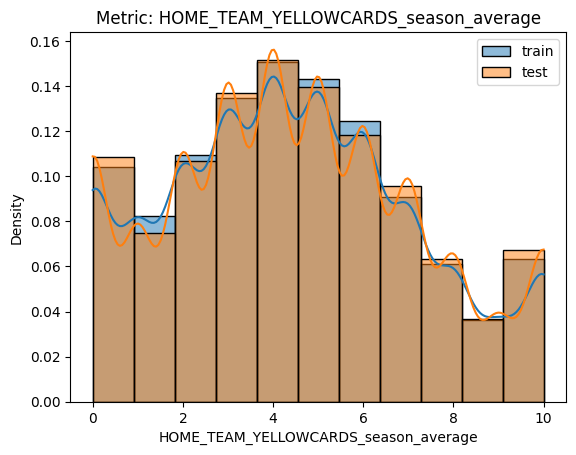

AWAY_TEAM_YELLOWCARDS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 1.4852726075000544 (loss = l1_loss)


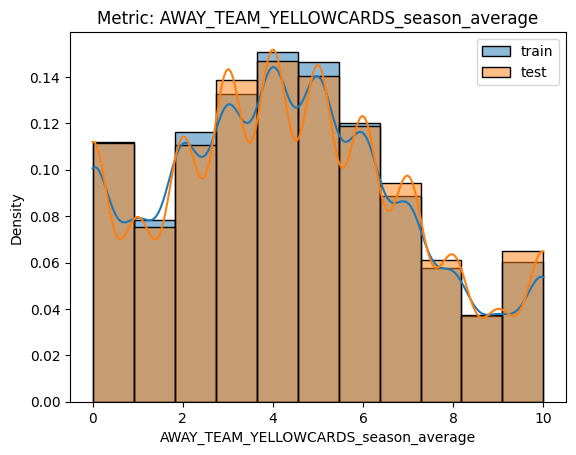

HOME_TEAM_OFFSIDES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 1.6500479316841696 (loss = l1_loss)


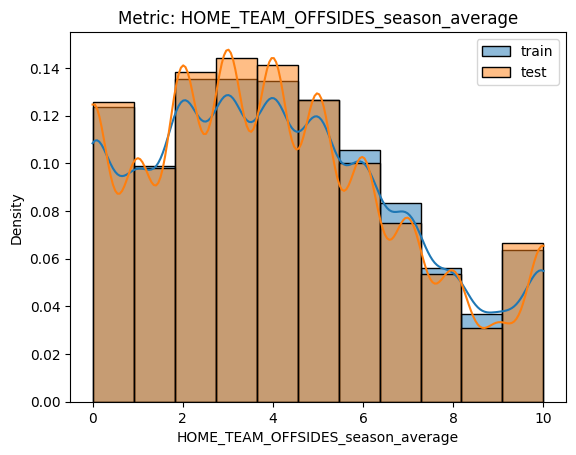

HOME_TEAM_SAVES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 1.8688980123861858 (loss = l1_loss)


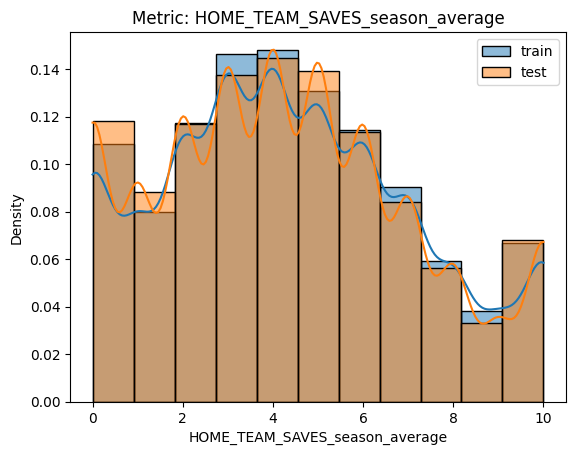

HOME_TEAM_CORNERS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 1.923901096951717 (loss = l1_loss)


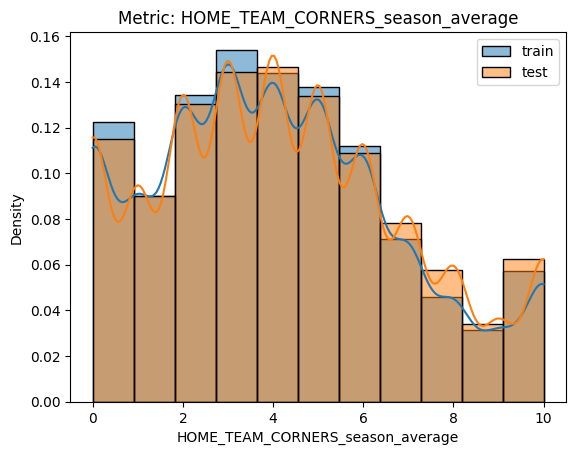

AWAY_TEAM_SAVES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 1.9959157475222082 (loss = l1_loss)


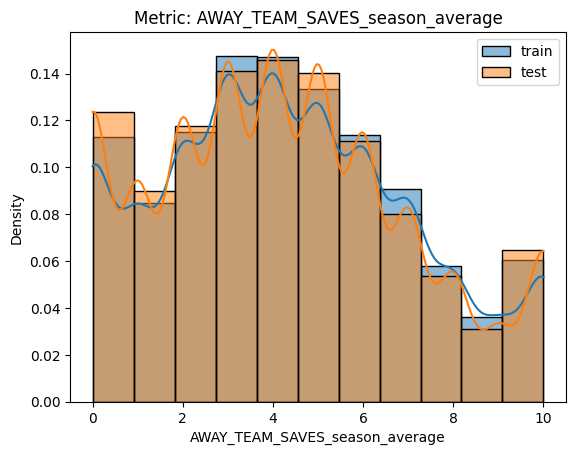

HOME_TEAM_SHOTS_OUTSIDEBOX_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.067158790155456 (loss = l1_loss)


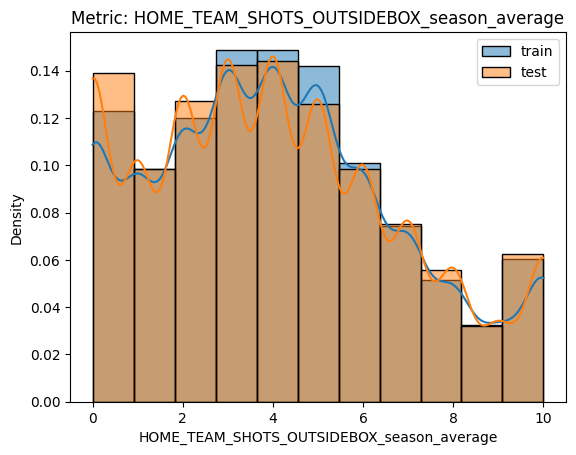

AWAY_TEAM_SHOTS_OUTSIDEBOX_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.09342847990279 (loss = l1_loss)


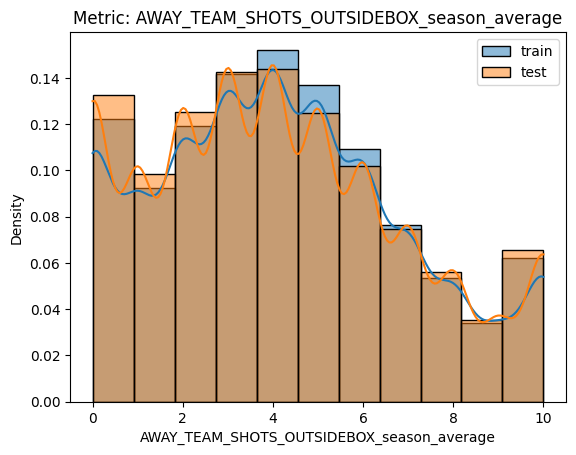

AWAY_TEAM_GAME_DRAW_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.110013425819798 (loss = l1_loss)


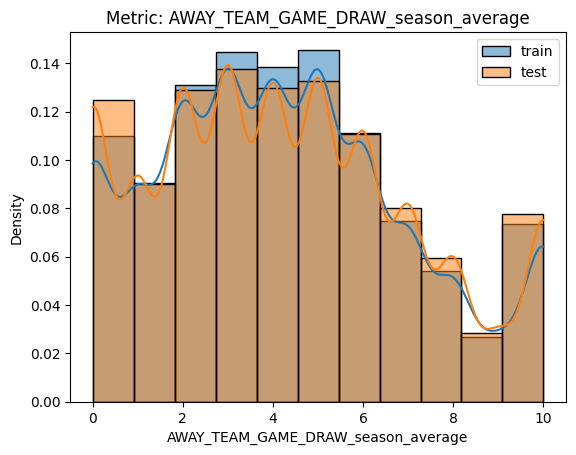

AWAY_TEAM_OFFSIDES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.1189666449769566 (loss = l1_loss)


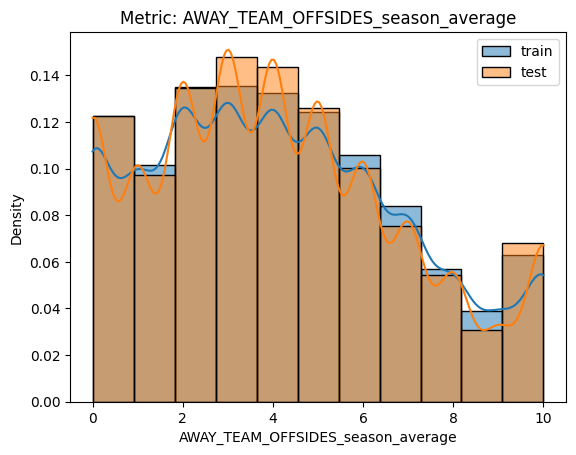

AWAY_TEAM_GOALS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.124443385355744 (loss = l1_loss)


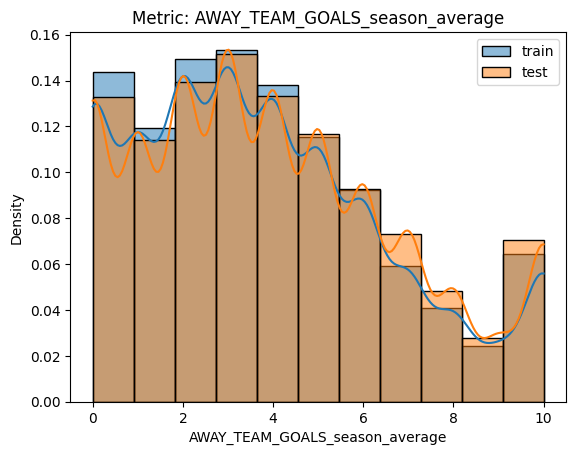

HOME_TEAM_GOALS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.1703773247859965 (loss = l1_loss)


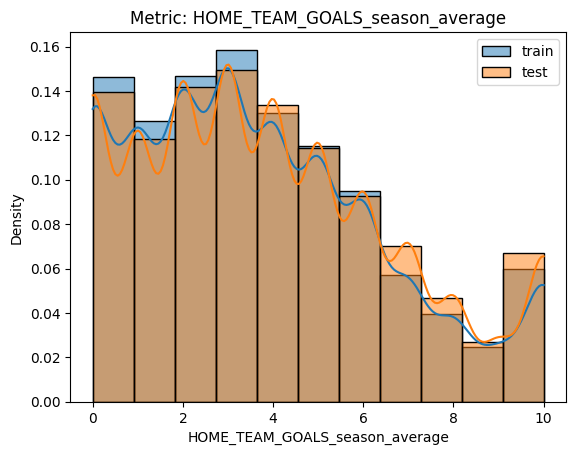

AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.264061725549556 (loss = l1_loss)


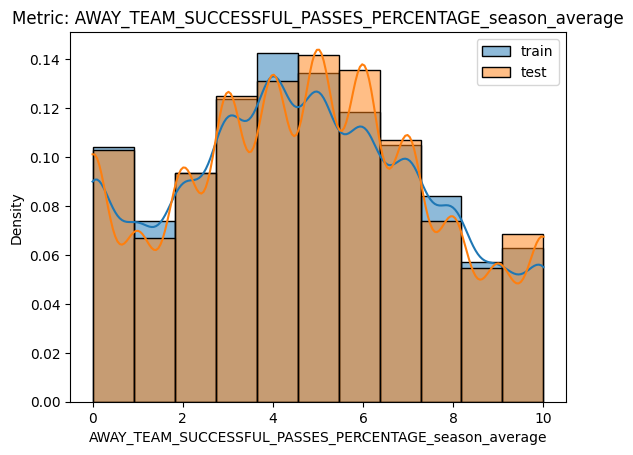

AWAY_TEAM_CORNERS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.279876510886116 (loss = l1_loss)


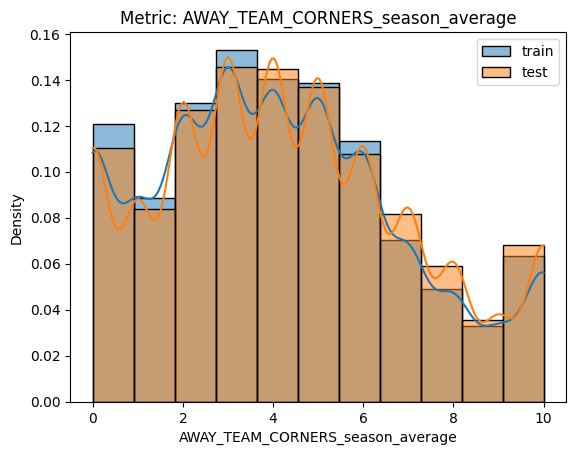

HOME_TEAM_GAME_DRAW_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.362389607233746 (loss = l1_loss)


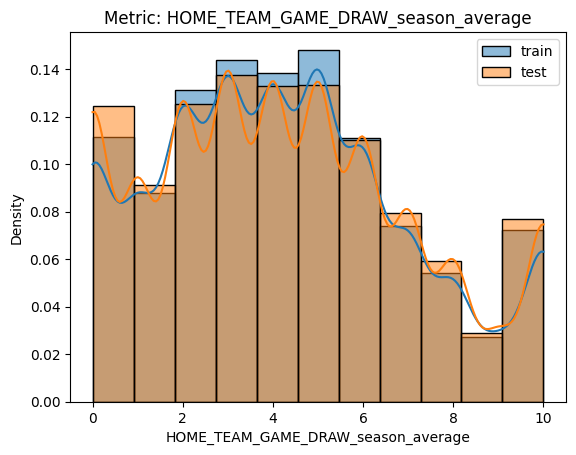

AWAY_TEAM_PENALTIES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.408577302666848 (loss = l1_loss)


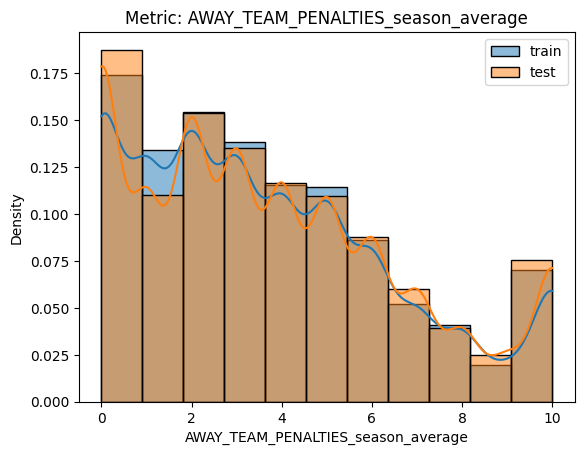

AWAY_TEAM_SHOTS_TOTAL_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.4154886069809938 (loss = l1_loss)


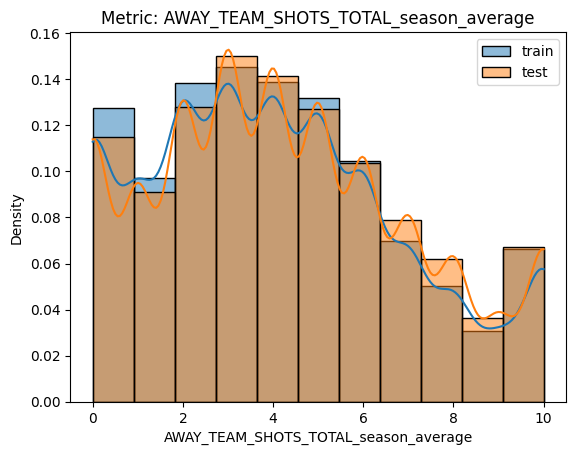

AWAY_TEAM_BALL_SAFE_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.4336840711075487 (loss = l1_loss)


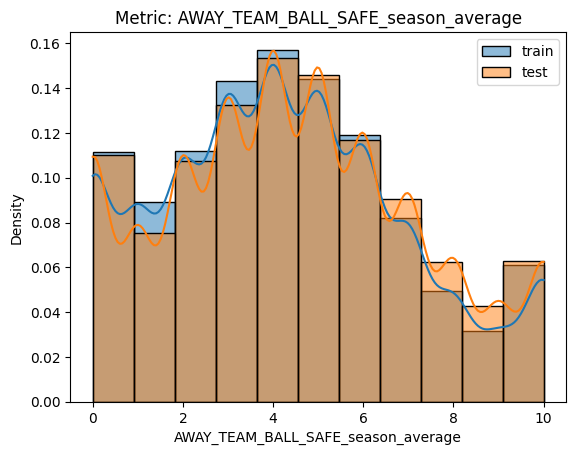

HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.50001749832457 (loss = l1_loss)


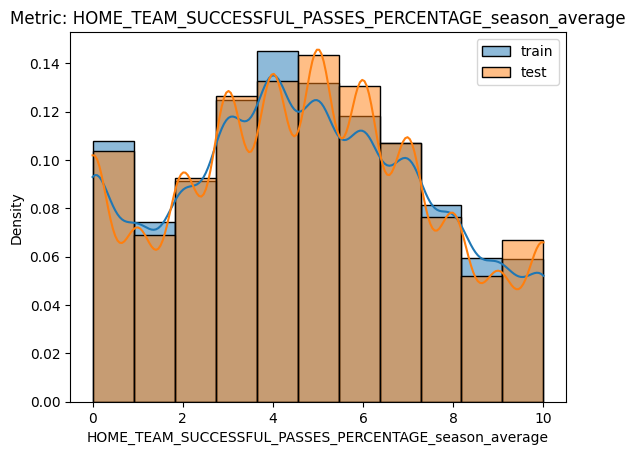

HOME_TEAM_PENALTIES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.5662318767198857 (loss = l1_loss)


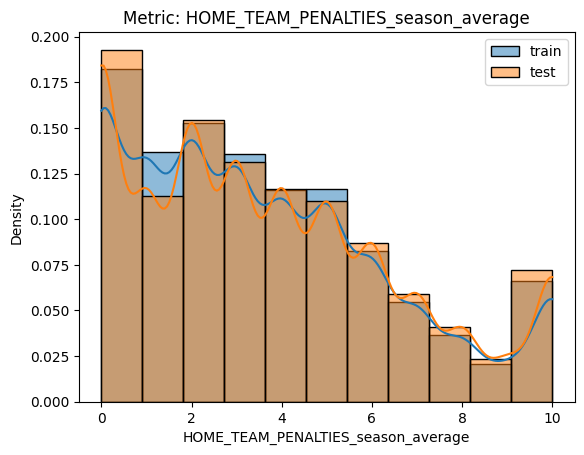

HOME_TEAM_REDCARDS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.6653819831484475 (loss = l1_loss)


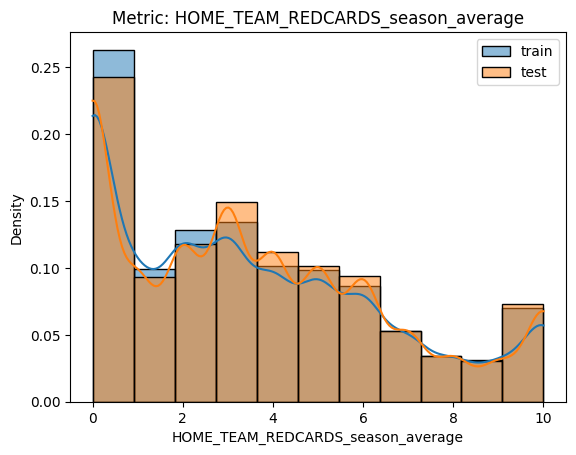

HOME_TEAM_GAME_LOST_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.693275793194976 (loss = l1_loss)


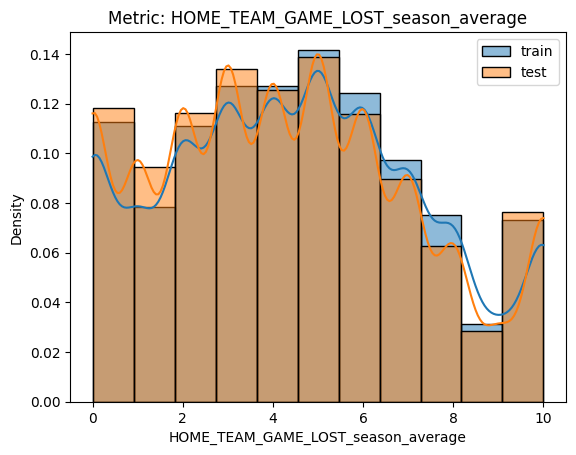

HOME_TEAM_SHOTS_TOTAL_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.743649421264697 (loss = l1_loss)


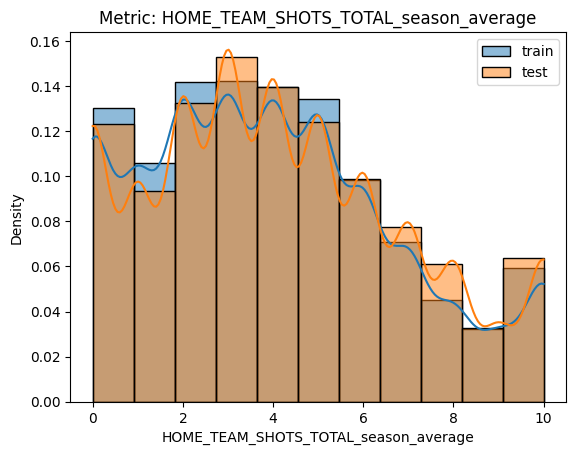

AWAY_TEAM_FOULS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.8246585109390123 (loss = l1_loss)


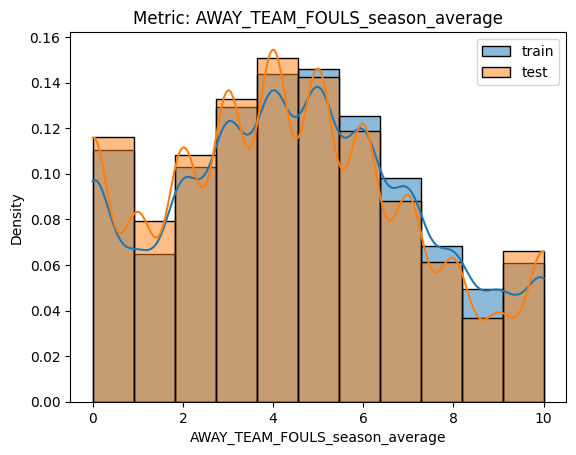

HOME_TEAM_SHOTS_OFF_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 2.9318615144834284 (loss = l1_loss)


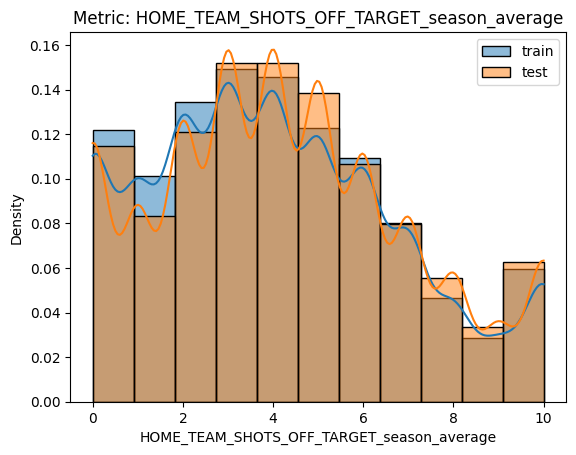

HOME_TEAM_SHOTS_INSIDEBOX_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.0600359995887167 (loss = l1_loss)


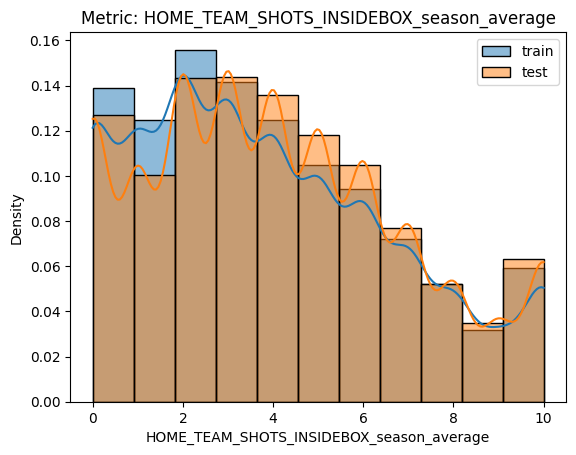

HOME_TEAM_BALL_SAFE_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.0796368687605415 (loss = l1_loss)


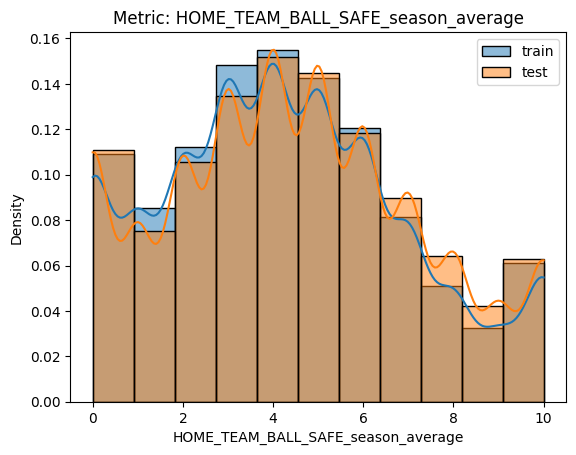

AWAY_TEAM_PASSES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.100197576348714 (loss = l1_loss)


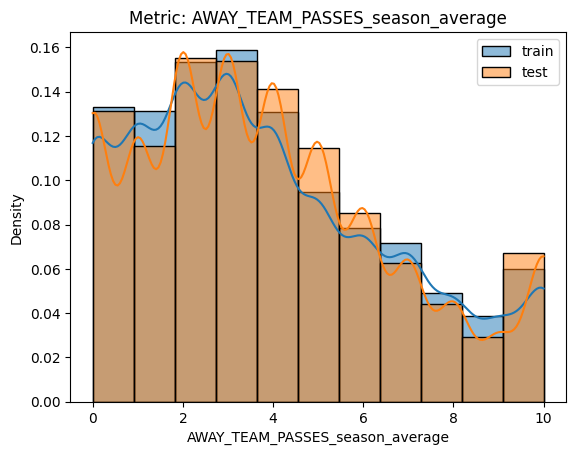

AWAY_TEAM_GAME_LOST_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.1098875809956903 (loss = l1_loss)


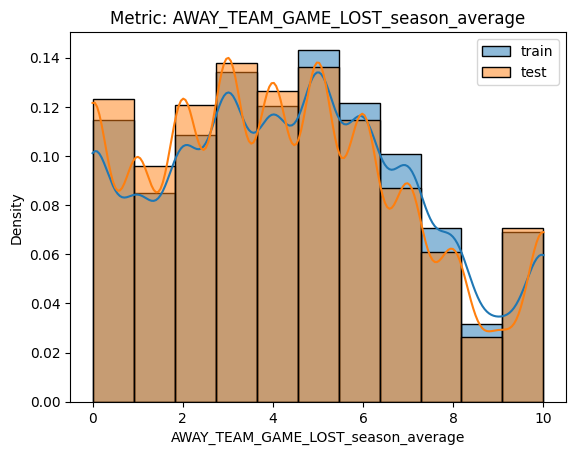

HOME_TEAM_FOULS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.1623054545657405 (loss = l1_loss)


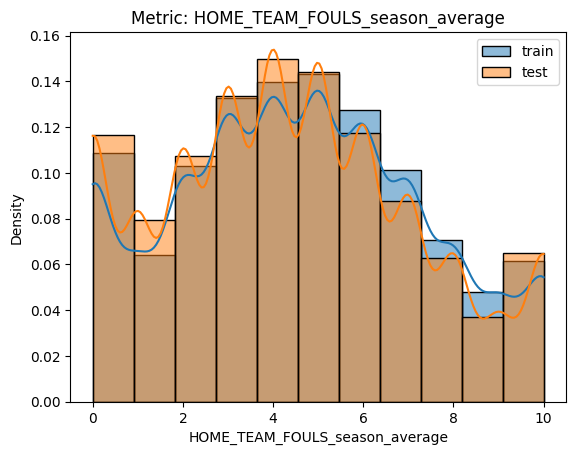

HOME_TEAM_SUCCESSFUL_PASSES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.172863227067814 (loss = l1_loss)


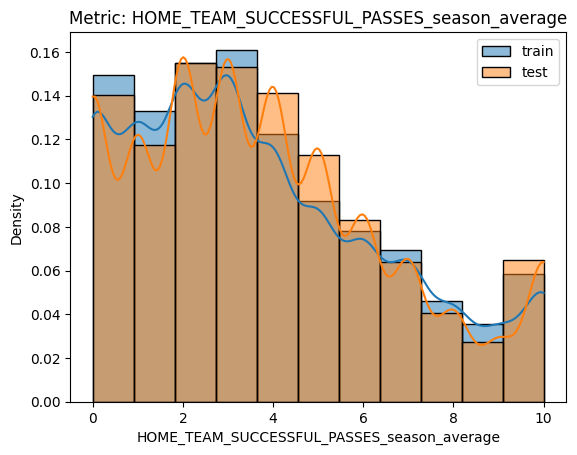

HOME_TEAM_INJURIES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.201420806826657 (loss = l1_loss)


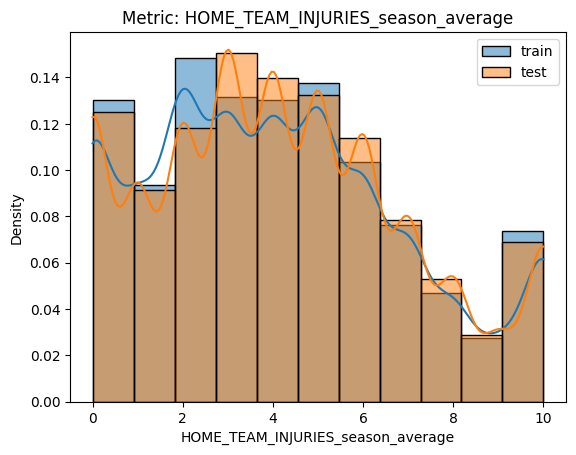

AWAY_TEAM_SHOTS_OFF_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.219912994312583 (loss = l1_loss)


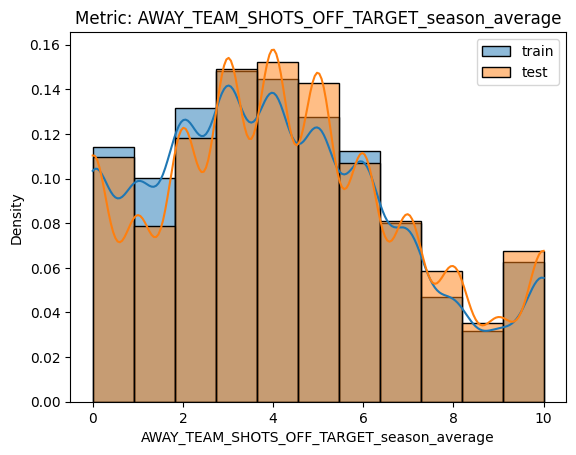

AWAY_TEAM_SHOTS_INSIDEBOX_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.3176200103633255 (loss = l1_loss)


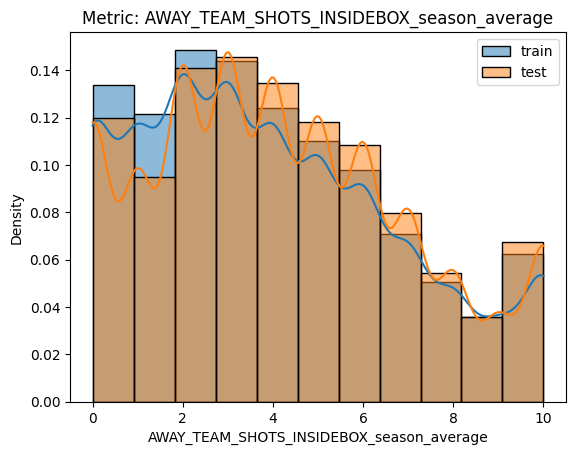

AWAY_TEAM_SUCCESSFUL_PASSES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.347457298694006 (loss = l1_loss)


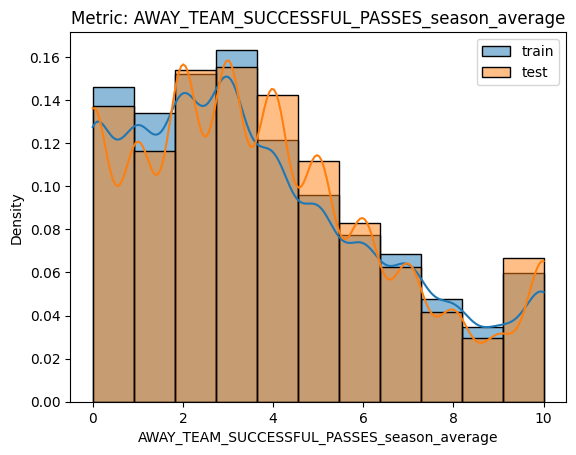

HOME_TEAM_DANGEROUS_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.3987677915046297 (loss = l1_loss)


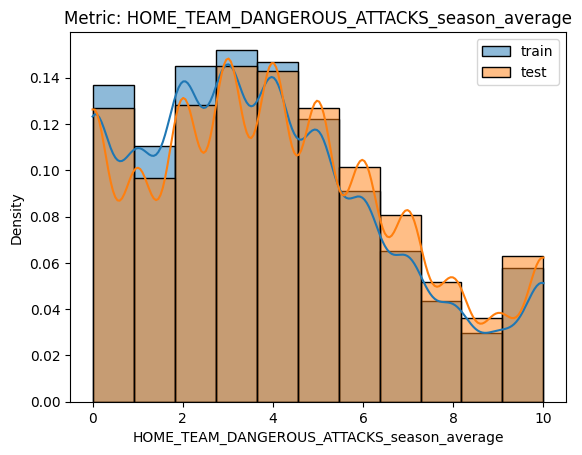

HOME_TEAM_BALL_POSSESSION_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.467730288141575 (loss = l1_loss)


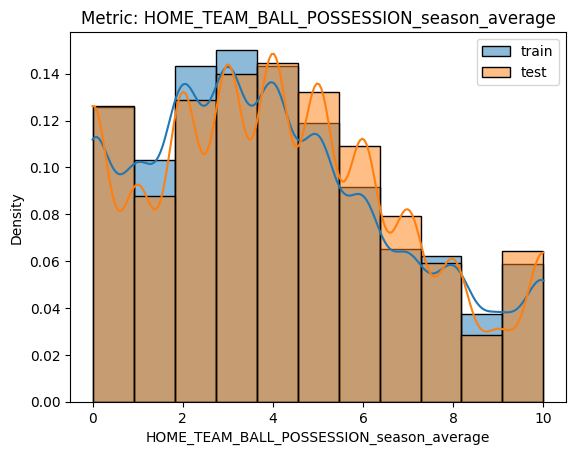

AWAY_TEAM_REDCARDS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.558731833979336 (loss = l1_loss)


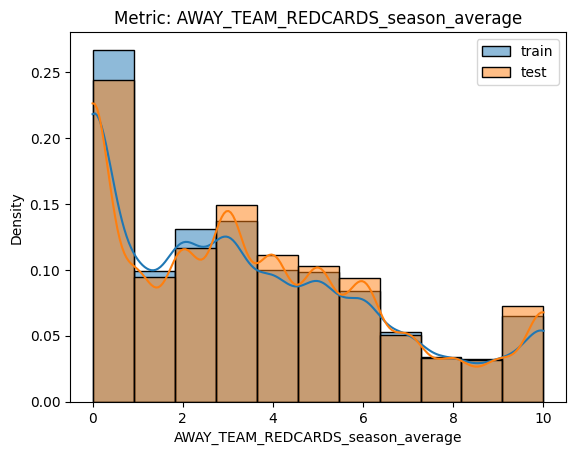

HOME_TEAM_PASSES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.5610520829766794 (loss = l1_loss)


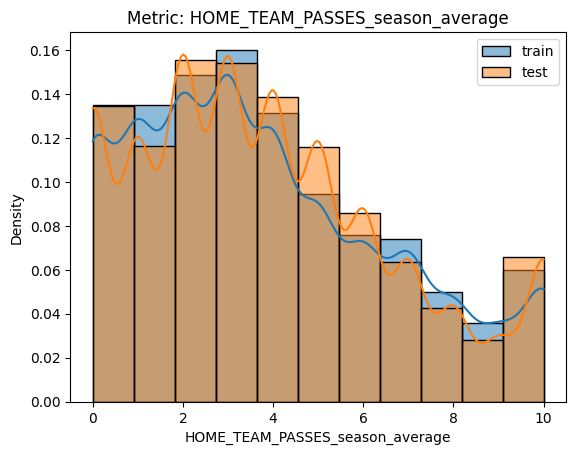

AWAY_TEAM_BALL_POSSESSION_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.5632763926414404 (loss = l1_loss)


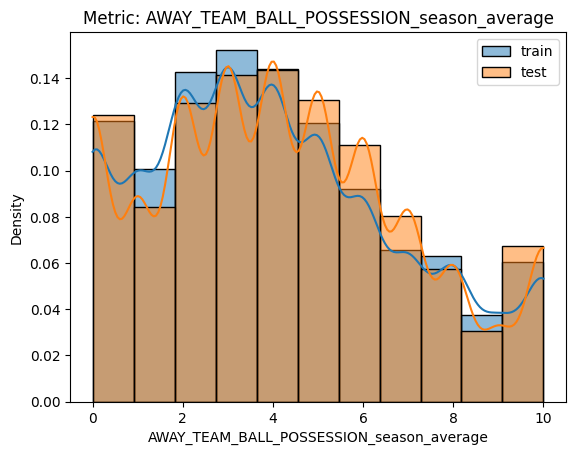

AWAY_TEAM_GAME_WON_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.6416128777091608 (loss = l1_loss)


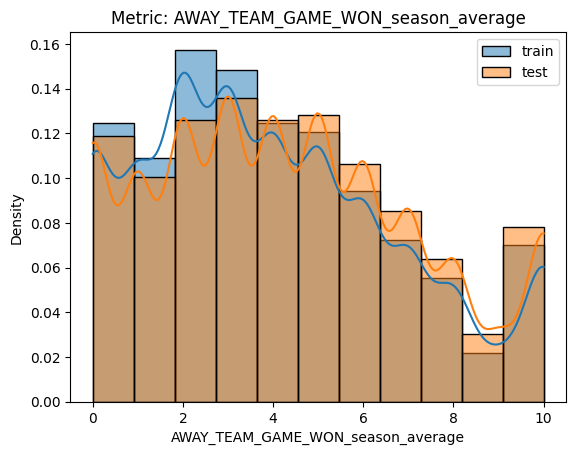

HOME_TEAM_GAME_WON_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.7043314071247693 (loss = l1_loss)


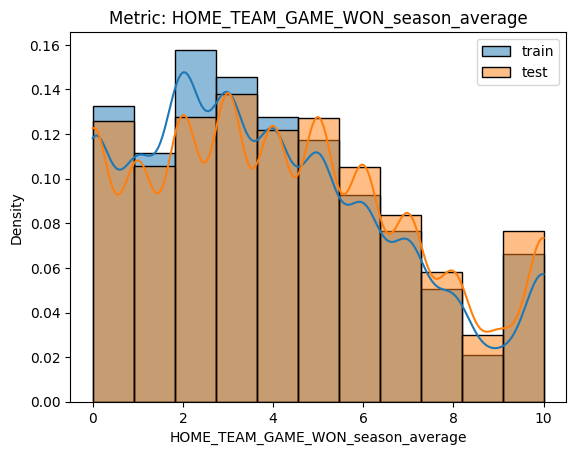

AWAY_TEAM_DANGEROUS_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.871659723281438 (loss = l1_loss)


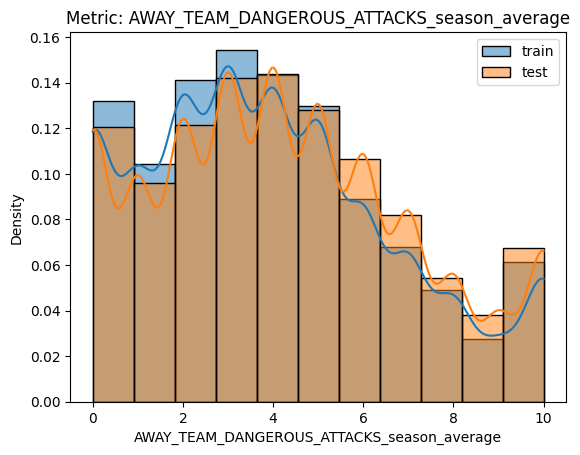

AWAY_TEAM_INJURIES_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 3.8914347203155084 (loss = l1_loss)


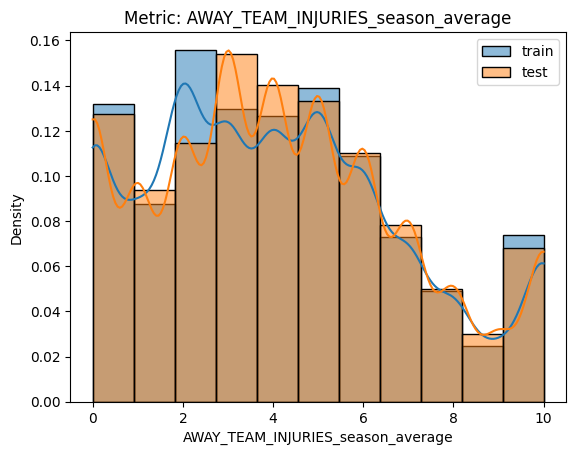

AWAY_TEAM_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.763850004201296 (loss = l1_loss)


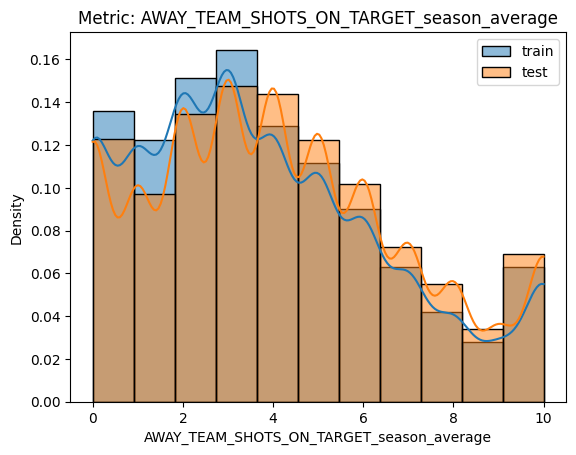

HOME_TEAM_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 4.951984703350647 (loss = l1_loss)


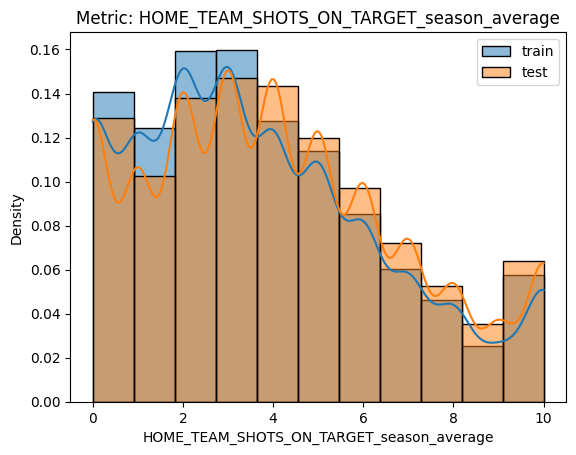

HOME_TEAM_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.338946568821388 (loss = l1_loss)


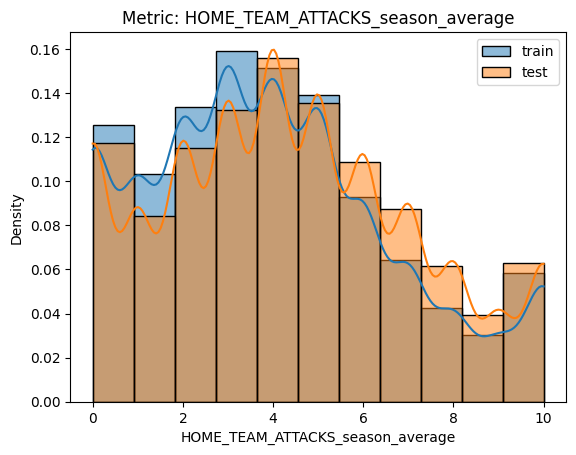

AWAY_TEAM_ATTACKS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.504091117500825 (loss = l1_loss)


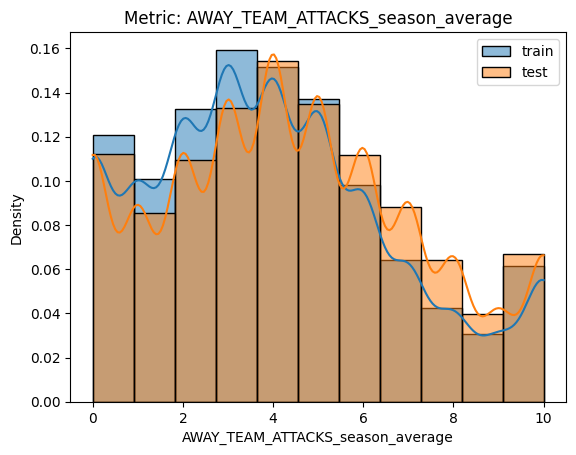

HOME_TEAM_SUBSTITUTIONS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 5.9316295379746755 (loss = l1_loss)


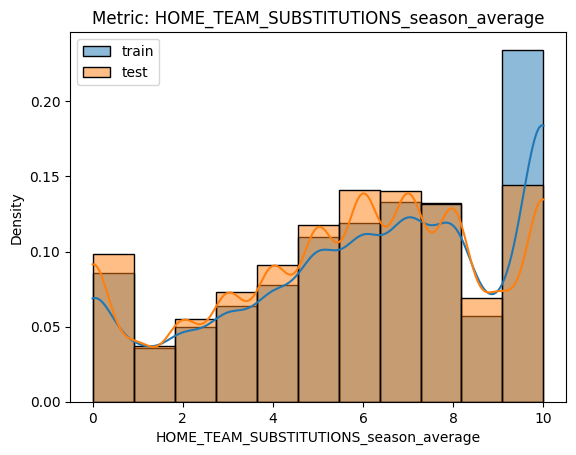

AWAY_TEAM_SUBSTITUTIONS_season_average train-distribution vs test-distribution difference (loss_value_normalized) : 7.2934761828679 (loss = l1_loss)


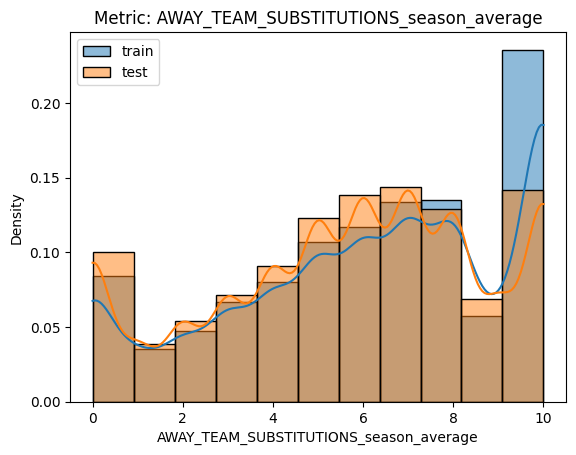

In [39]:
for column_name, loss_name_to_loss_values in sorted(metric_names_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=False):
    print(f"{column_name} train-distribution vs test-distribution difference ({LOSS_STATISTIC}) : {loss_name_to_loss_values[LOSS_NAME][LOSS_STATISTIC]} (loss = {LOSS_NAME})")
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {column_name}")
    sns.histplot(df_teamfeatures_train[column_name], kde=True, label="train", stat='density', bins=11)
    sns.histplot(df_teamfeatures_test[column_name], kde=True, label="test", stat='density', bins=11)
    plt.legend()
    plt.show()

Here we log the metrics in terms of difference between the train and test distributions.

In [40]:
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']

import yaml

from src.data_analysis import feature_name_to_metric_name
path = "data/normalized_differences_teams.yaml"
dict_to_save = {}
for column_name, loss_name_to_loss_values in metric_names_to_loss_name_to_loss_values.items():
    loss_value = loss_name_to_loss_values[LOSS_NAME][LOSS_STATISTIC]
    metric_name = feature_name_to_metric_name(column_name)
    print(metric_name)
    dict_to_save[metric_name] = float(loss_value)
print(dict_to_save)
with open(path
            , 'w') as file:
        documents = yaml.dump(dict_to_save, file)
        


HOME_TEAM_SHOTS_TOTAL
HOME_TEAM_SHOTS_INSIDEBOX
HOME_TEAM_SHOTS_OFF_TARGET
HOME_TEAM_SHOTS_ON_TARGET
HOME_TEAM_SHOTS_OUTSIDEBOX
HOME_TEAM_PASSES
HOME_TEAM_SUCCESSFUL_PASSES
HOME_TEAM_SAVES
HOME_TEAM_CORNERS
HOME_TEAM_FOULS
HOME_TEAM_YELLOWCARDS
HOME_TEAM_REDCARDS
HOME_TEAM_OFFSIDES
HOME_TEAM_ATTACKS
HOME_TEAM_PENALTIES
HOME_TEAM_SUBSTITUTIONS
HOME_TEAM_BALL_SAFE
HOME_TEAM_DANGEROUS_ATTACKS
HOME_TEAM_INJURIES
HOME_TEAM_GOALS
HOME_TEAM_GAME_WON
HOME_TEAM_GAME_DRAW
HOME_TEAM_GAME_LOST
HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE
HOME_TEAM_BALL_POSSESSION
AWAY_TEAM_SHOTS_TOTAL
AWAY_TEAM_SHOTS_INSIDEBOX
AWAY_TEAM_SHOTS_OFF_TARGET
AWAY_TEAM_SHOTS_ON_TARGET
AWAY_TEAM_SHOTS_OUTSIDEBOX
AWAY_TEAM_PASSES
AWAY_TEAM_SUCCESSFUL_PASSES
AWAY_TEAM_SAVES
AWAY_TEAM_CORNERS
AWAY_TEAM_FOULS
AWAY_TEAM_YELLOWCARDS
AWAY_TEAM_REDCARDS
AWAY_TEAM_OFFSIDES
AWAY_TEAM_ATTACKS
AWAY_TEAM_PENALTIES
AWAY_TEAM_SUBSTITUTIONS
AWAY_TEAM_BALL_SAFE
AWAY_TEAM_DANGEROUS_ATTACKS
AWAY_TEAM_INJURIES
AWAY_TEAM_GOALS
AWAY_TEAM_GAME_WON
A

## Player features

In [41]:
from src.data_loading import load_dataframe_playersfeatures
df_playersfeatures_train, _ = load_dataframe_playersfeatures('train')   # we only take the HOME players features
df_playersfeatures_test, _ = load_dataframe_playersfeatures('test')

We plot the top playermetrics season averaged distributions for train in test, in terms of difference between the two distributions.

Some of them are top because for some reason the train data is totally incomplete (NaN in the data, and so we assign a uniform distribution).

Missing season_average for ID
Missing season_average for LEAGUE
Missing season_average for TEAM_NAME
Missing season_average for POSITION
Missing season_average for PLAYER_NAME
PLAYER_SHOTS_OFF_TARGET_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.014768374489462801, 'estimated_typical_loss_value': 0.00014532224950368516, 'loss_value_normalized': 101.62500608047449}


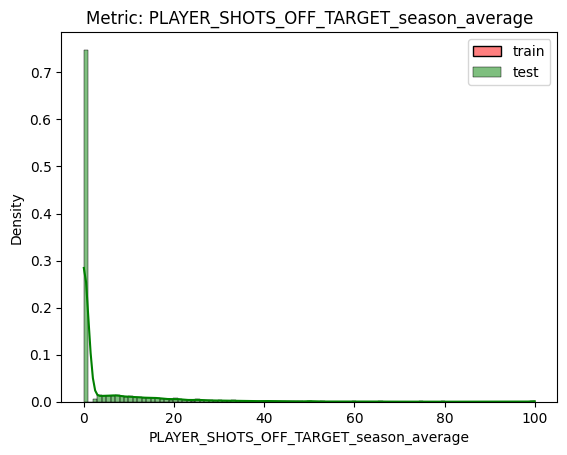

PLAYER_LONG_BALLS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0143132240421329, 'estimated_typical_loss_value': 0.00015485298902583608, 'loss_value_normalized': 92.43104787421521}


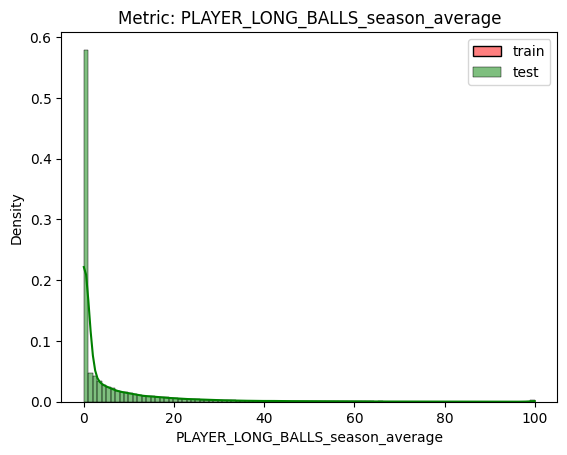

PLAYER_LONG_BALLS_WON_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.014073307837256169, 'estimated_typical_loss_value': 0.00015781615172813398, 'loss_value_normalized': 89.17533270916472}


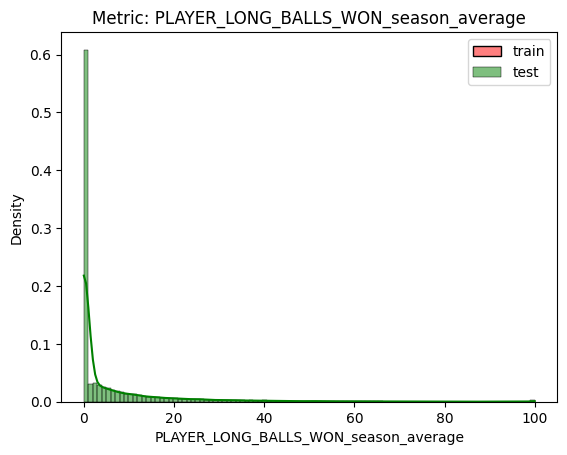

PLAYER_DUELS_LOST_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0019679643555201355, 'estimated_typical_loss_value': 0.00015804040482519135, 'loss_value_normalized': 12.452286221957845}


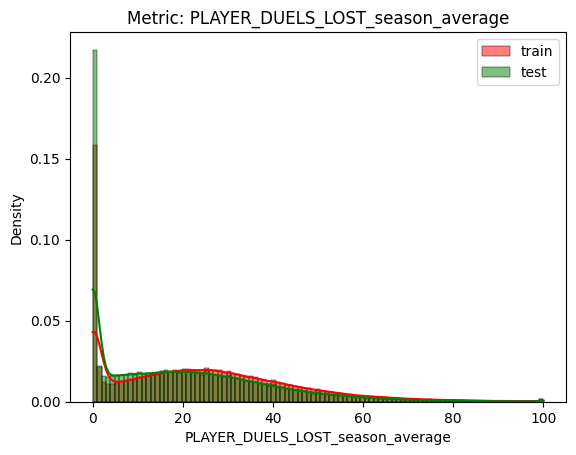

PLAYER_BLOCKED_SHOTS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0013479392661491284, 'estimated_typical_loss_value': 0.00011537809712667743, 'loss_value_normalized': 11.682800286319397}


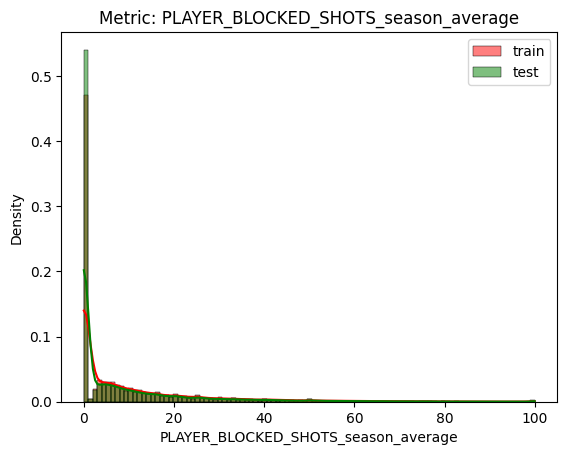

PLAYER_ERROR_LEAD_TO_GOAL_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0003332430629015705, 'estimated_typical_loss_value': 4.5729204015195405e-05, 'loss_value_normalized': 7.2873138747225665}


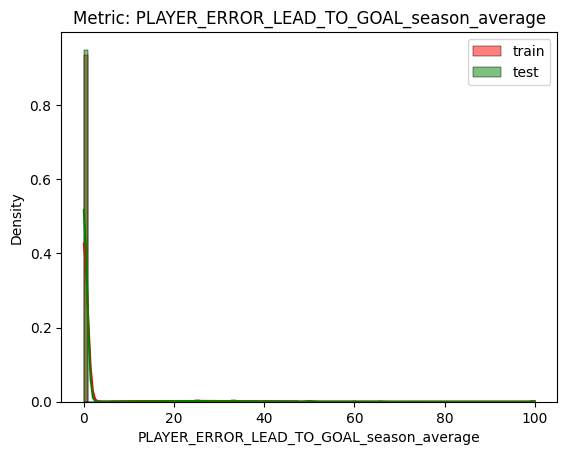

PLAYER_GOALS_CONCEDED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0010261286738614316, 'estimated_typical_loss_value': 0.00014536115268632327, 'loss_value_normalized': 7.0591671495214445}


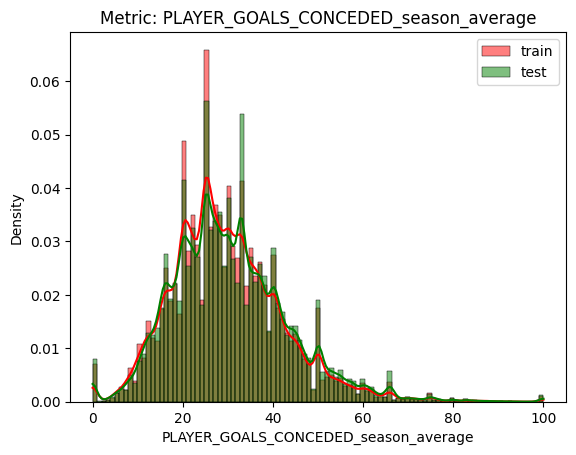

PLAYER_BIG_CHANCES_MISSED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0006578943336548321, 'estimated_typical_loss_value': 9.446710713613929e-05, 'loss_value_normalized': 6.964268871970167}


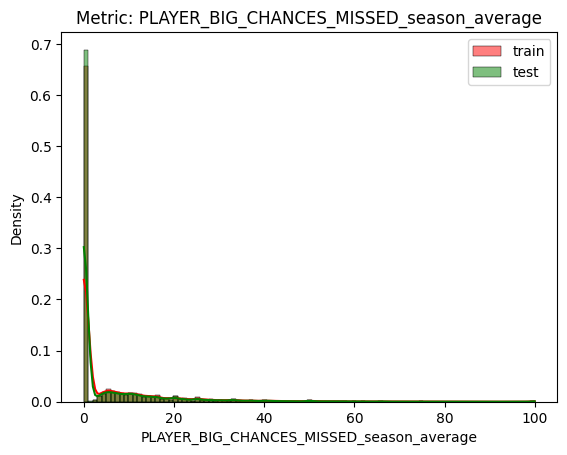

PLAYER_ASSISTS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000657890853013773, 'estimated_typical_loss_value': 9.735988733995634e-05, 'loss_value_normalized': 6.757309103235529}


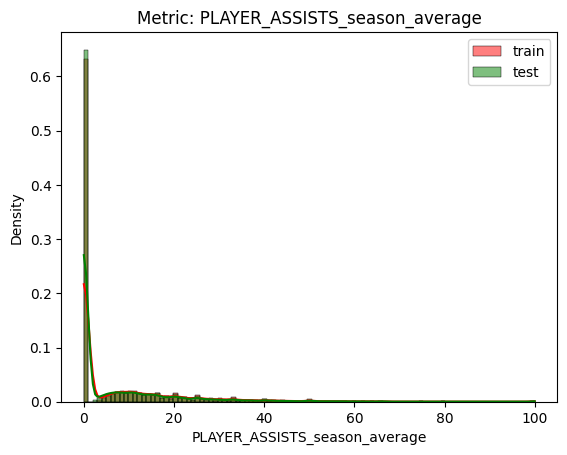

PLAYER_BIG_CHANCES_CREATED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0007035230125301567, 'estimated_typical_loss_value': 0.00010890239397190113, 'loss_value_normalized': 6.460124400114147}


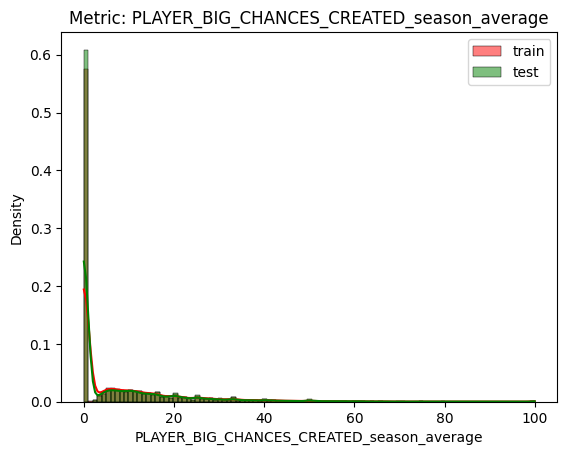

In [42]:
from src.data_analysis import get_metrics_names_to_fn_names, compute_distribution_difference, loss_name_to_loss_fn

column_names_to_fn_names = get_metrics_names_to_fn_names(df_playersfeatures_train)
metric_names_to_loss_name_to_loss_values : Dict[str, Dict[str, float]] = {}
metric_names_to_loss_name_to_loss_values_train_1st_half_vs_2nd_half : Dict[str, Dict[str, float]] = {}
metric_names_to_loss_name_to_loss_values_test_1st_half_vs_2nd_half : Dict[str, Dict[str, float]] = {}
for metric_name, list_fn_names in column_names_to_fn_names.items():
    # Skip metrics that doesnt have the season_average function (i.e. non-aggregated metrics I believe)
    if 'season_average' not in list_fn_names:
        print(f"Missing season_average for {metric_name}")
        continue
    column_name = f"{metric_name}_season_average"
    # Compute the distribution difference
    serie_train = df_playersfeatures_train[column_name]
    serie_train_shuffled = serie_train.sample(frac=1).reset_index(drop=True)
    serie_test = df_playersfeatures_test[column_name]
    serie_test_shuffled = serie_test.sample(frac=1).reset_index(drop=True)
    metric_names_to_loss_name_to_loss_values[column_name] = compute_distribution_difference(
        feature_serie1=serie_train,
        feature_serie2=serie_test,
        n_monte_carlo=n_monte_carlo,
        n_value_max=101,
        )
    metric_names_to_loss_name_to_loss_values_train_1st_half_vs_2nd_half[column_name] = compute_distribution_difference(
        feature_serie1=serie_train_shuffled[:len(serie_train)//2],
        feature_serie2=serie_train_shuffled[len(serie_train)//2:],
        n_monte_carlo=n_monte_carlo,
        n_value_max=101,
        )
    metric_names_to_loss_name_to_loss_values_test_1st_half_vs_2nd_half[column_name] = compute_distribution_difference(
        feature_serie1=serie_test_shuffled[:len(serie_test)//2],
        feature_serie2=serie_test_shuffled[len(serie_test)//2:],
        n_monte_carlo=n_monte_carlo,
        n_value_max=101,
        )
    
# Print top differences
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']
n_top_metrics_to_plot = 10
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
for column_name, loss_name_to_loss_values in sorted(metric_names_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=True)[:n_top_metrics_to_plot]:
    print(f"{column_name} train-distribution vs test-distribution difference ({LOSS_NAME} normalized): {loss_name_to_loss_values[LOSS_NAME]}")
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {column_name}")
    sns.histplot(df_playersfeatures_train[column_name], kde=True, label="train", color='red', stat='density', bins=101)
    sns.histplot(df_playersfeatures_test[column_name], kde=True, label="test", color='green', stat='density', bins=101)
    plt.legend()
    plt.show()

We plot here the distribution of those differences.

As we can see, if LOSS_STATISTIC = 'loss_value_normalized', a lot of metrics have a normalized difference equal or even inferor to 1, which means that the train and test distributions are not notably different, and even possibly not independent.

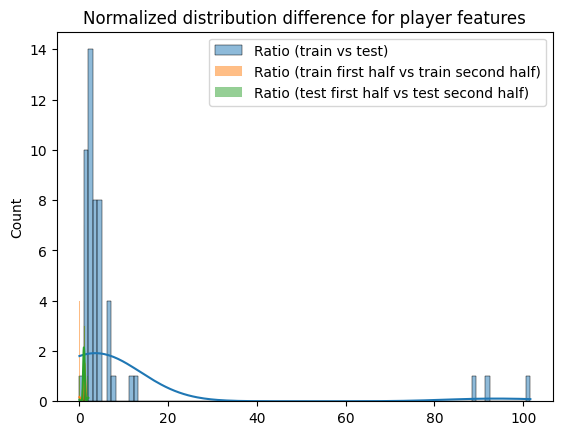

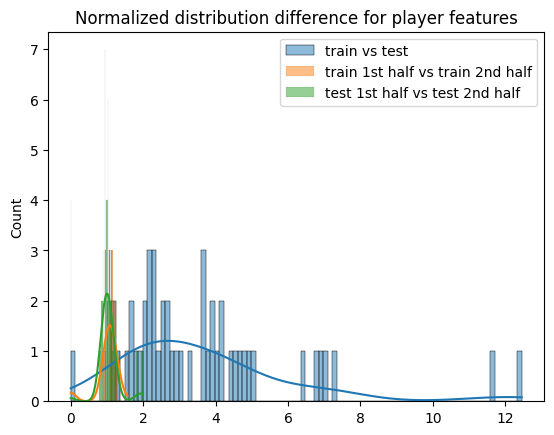

In [43]:
LOSS_NAME = 'l1_loss'
LOSS_STATISTIC = 'loss_value_normalized'

fig, ax = plt.subplots()
ax.set_title(f"Normalized distribution difference for player features")

# Histogram of the distribution of the normalized losses
loss_value_normalized_values_train_vs_test = list(metric_names_to_loss_name_to_loss_values.values())
loss_value_normalized_values_train_vs_test = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_train_vs_test]
sns.histplot(loss_value_normalized_values_train_vs_test, kde=True, label="Ratio (train vs test)", bins=100)

# Histogram of the distribution of the typical losses between train feature distribution first half and second half
loss_value_normalized_values_train_1st_half_vs_2nd_half = list(metric_names_to_loss_name_to_loss_values_train_1st_half_vs_2nd_half.values())
loss_value_normalized_values_train_1st_half_vs_2nd_half = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_train_1st_half_vs_2nd_half]
sns.histplot(loss_value_normalized_values_train_1st_half_vs_2nd_half, kde=True, label="Ratio (train first half vs train second half)", bins=100)

# Histogram of the distribution of the typical losses between test feature distribution first half and second half
loss_value_normalized_values_test_1st_half_vs_2nd_half = list(metric_names_to_loss_name_to_loss_values_test_1st_half_vs_2nd_half.values())
loss_value_normalized_values_test_1st_half_vs_2nd_half = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_test_1st_half_vs_2nd_half]
sns.histplot(loss_value_normalized_values_test_1st_half_vs_2nd_half, kde=True, label="Ratio (test first half vs test second half)", bins=100)

plt.legend()



# Do the same but remove the losses above 20
fig, ax = plt.subplots()
ax.set_title(f"Normalized distribution difference for player features")

loss_value_normalized_values_train_vs_test = list(metric_names_to_loss_name_to_loss_values.values())
loss_value_normalized_values_train_vs_test = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_train_vs_test]
loss_value_normalized_values_train_vs_test = [elem for elem in loss_value_normalized_values_train_vs_test if elem < 20]
sns.histplot(loss_value_normalized_values_train_vs_test, kde=True, label="train vs test", bins=100)

loss_value_normalized_values_train_1st_half_vs_2nd_half = list(metric_names_to_loss_name_to_loss_values_train_1st_half_vs_2nd_half.values())
loss_value_normalized_values_train_1st_half_vs_2nd_half = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_train_1st_half_vs_2nd_half]
loss_value_normalized_values_train_1st_half_vs_2nd_half = [elem for elem in loss_value_normalized_values_train_1st_half_vs_2nd_half if elem < 20]
sns.histplot(loss_value_normalized_values_train_1st_half_vs_2nd_half, kde=True, label="train 1st half vs train 2nd half", bins=100)

loss_value_normalized_values_test_1st_half_vs_2nd_half = list(metric_names_to_loss_name_to_loss_values_test_1st_half_vs_2nd_half.values())
loss_value_normalized_values_test_1st_half_vs_2nd_half = [elem[LOSS_NAME][LOSS_STATISTIC] for elem in loss_value_normalized_values_test_1st_half_vs_2nd_half]
loss_value_normalized_values_test_1st_half_vs_2nd_half = [elem for elem in loss_value_normalized_values_test_1st_half_vs_2nd_half if elem < 20]
sns.histplot(loss_value_normalized_values_test_1st_half_vs_2nd_half, kde=True, label="test 1st half vs test 2nd half", bins=100)

plt.legend()


Here we log the metrics in terms of difference between the train and test distributions.

In [44]:
LOSS_NAME = 'l1_loss'
assert LOSS_NAME in loss_name_to_loss_fn.keys(), f"{LOSS_NAME} not in {loss_name_to_loss_fn.keys()}"
LOSS_STATISTIC = 'loss_value_normalized'
assert LOSS_STATISTIC in ['loss_value', 'loss_value_normalized', 'estimated_typical_loss_value']

import yaml

from src.data_analysis import feature_name_to_metric_name
path = "data/normalized_differences_players.yaml"
dict_to_save = {}
for column_name, loss_name_to_loss_values in metric_names_to_loss_name_to_loss_values.items():
    loss_value = loss_name_to_loss_values[LOSS_NAME][LOSS_STATISTIC]
    metric_name = feature_name_to_metric_name(column_name)
    print(metric_name)
    dict_to_save[metric_name] = float(loss_value)
print(dict_to_save)
with open(path
            , 'w') as file:
        documents = yaml.dump(dict_to_save, file)
        


PLAYER_ACCURATE_CROSSES
PLAYER_ACCURATE_PASSES
PLAYER_AERIALS_WON
PLAYER_ASSISTS
PLAYER_BIG_CHANCES_CREATED
PLAYER_BIG_CHANCES_MISSED
PLAYER_BLOCKED_SHOTS
PLAYER_CAPTAIN
PLAYER_CLEARANCES
PLAYER_CLEARANCE_OFFLINE
PLAYER_DISPOSSESSED
PLAYER_DRIBBLED_ATTEMPTS
PLAYER_DRIBBLED_PAST
PLAYER_DUELS_LOST
PLAYER_DUELS_WON
PLAYER_ERROR_LEAD_TO_GOAL
PLAYER_FOULS
PLAYER_FOULS_DRAWN
PLAYER_GOALKEEPER_GOALS_CONCEDED
PLAYER_GOALS
PLAYER_GOALS_CONCEDED
PLAYER_HIT_WOODWORK
PLAYER_INTERCEPTIONS
PLAYER_KEY_PASSES
PLAYER_MINUTES_PLAYED
PLAYER_OFFSIDES
PLAYER_OWN_GOALS
PLAYER_PASSES
PLAYER_PENALTIES_COMMITTED
PLAYER_PENALTIES_MISSES
PLAYER_PENALTIES_SAVED
PLAYER_PENALTIES_SCORED
PLAYER_PENALTIES_WON
PLAYER_REDCARDS
PLAYER_SAVES
PLAYER_SAVES_INSIDE_BOX
PLAYER_SHOTS_BLOCKED
PLAYER_SHOTS_ON_TARGET
PLAYER_SHOTS_TOTAL
PLAYER_STARTING_LINEUP
PLAYER_SUCCESSFUL_DRIBBLES
PLAYER_TACKLES
PLAYER_TOTAL_CROSSES
PLAYER_TOTAL_DUELS
PLAYER_YELLOWCARDS
PLAYER_PUNCHES
PLAYER_LONG_BALLS
PLAYER_LONG_BALLS_WON
PLAYER_SHOTS_OFF_T

Below we plot every player feature distribution in train and test.

PLAYER_CAPTAIN_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0, 'estimated_typical_loss_value': 0.00019267420722317516, 'loss_value_normalized': 0.0}


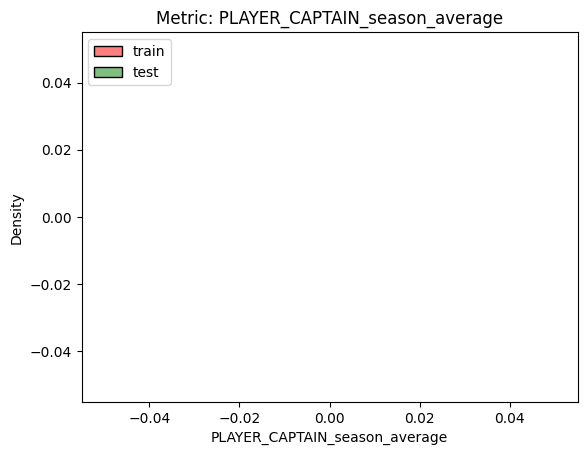

PLAYER_GOALKEEPER_GOALS_CONCEDED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 6.658571125043592e-05, 'estimated_typical_loss_value': 5.395844036628182e-05, 'loss_value_normalized': 1.2340184556514864}


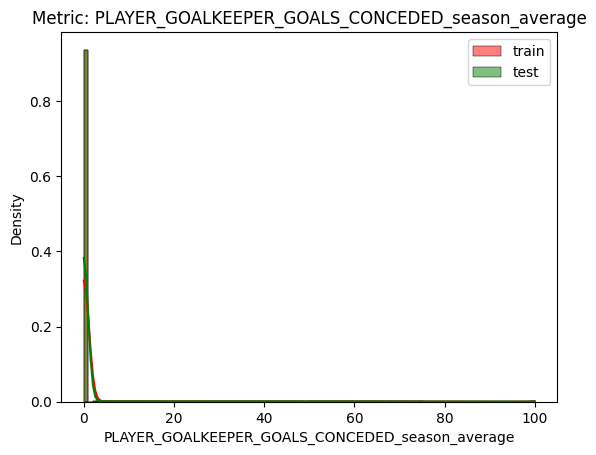

PLAYER_SAVES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 6.959632160165597e-05, 'estimated_typical_loss_value': 5.609865617092315e-05, 'loss_value_normalized': 1.240605860313877}


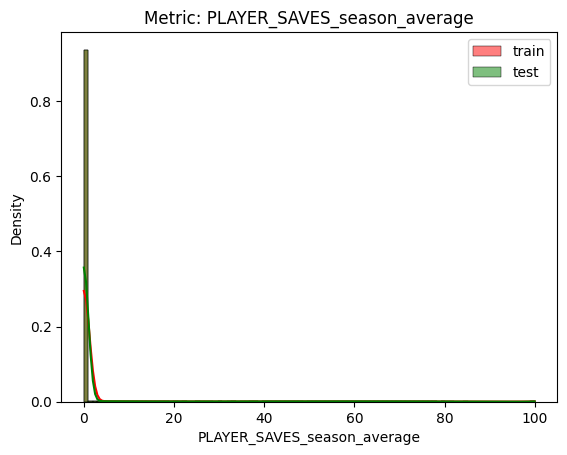

PLAYER_SAVES_INSIDE_BOX_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 7.279413067485986e-05, 'estimated_typical_loss_value': 5.5122585170580955e-05, 'loss_value_normalized': 1.3205862977815672}


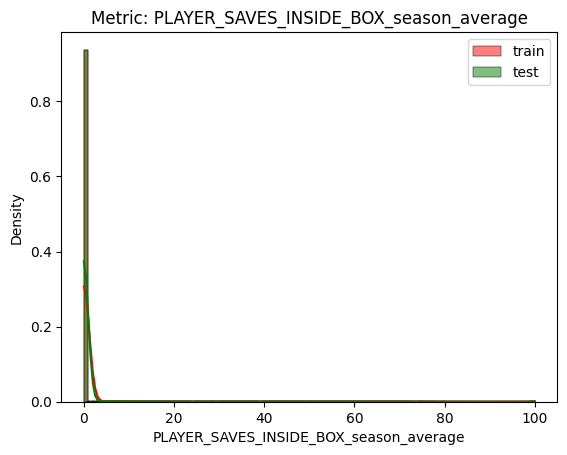

PLAYER_PENALTIES_SAVED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 4.0626321255459884e-05, 'estimated_typical_loss_value': 2.5474952631985784e-05, 'loss_value_normalized': 1.5947555169973613}


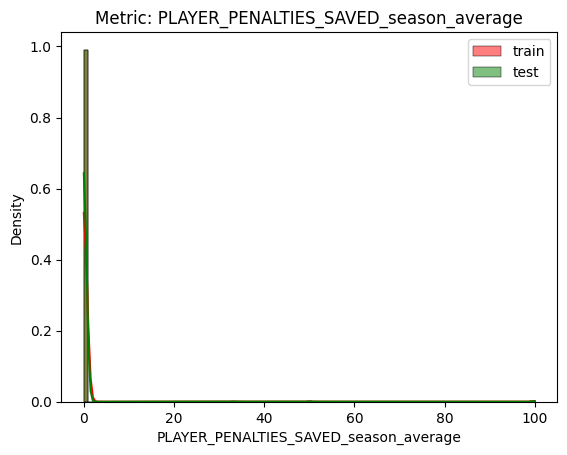

PLAYER_FOULS_DRAWN_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00024930046640725623, 'estimated_typical_loss_value': 0.00014968858202411725, 'loss_value_normalized': 1.6654608055991877}


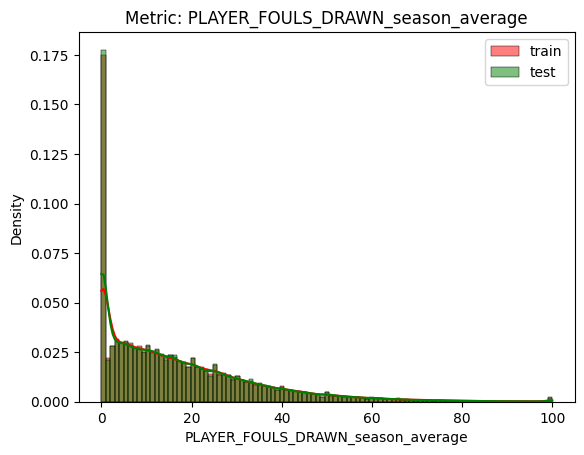

PLAYER_DUELS_WON_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0003031442299879707, 'estimated_typical_loss_value': 0.00017610735042483547, 'loss_value_normalized': 1.7213604614247702}


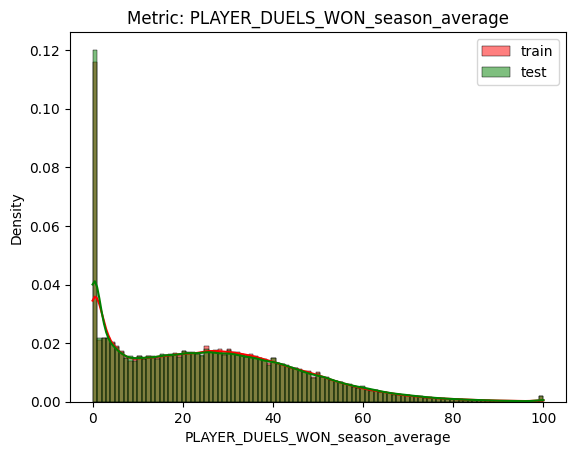

PLAYER_PUNCHES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 8.54837579652825e-05, 'estimated_typical_loss_value': 4.7640978847657156e-05, 'loss_value_normalized': 1.7943325270086874}


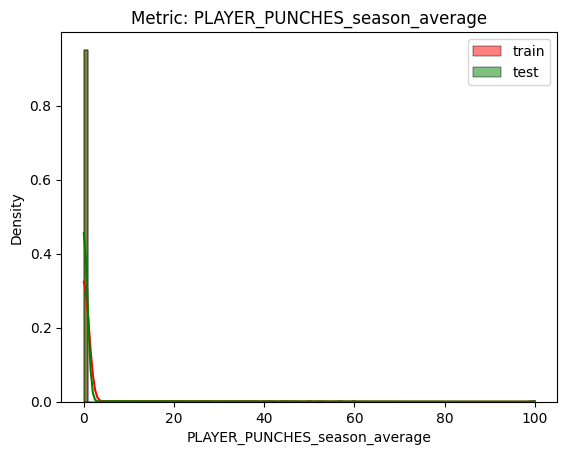

PLAYER_TOTAL_CROSSES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00024245613637704016, 'estimated_typical_loss_value': 0.0001253007040905183, 'loss_value_normalized': 1.9349942056307852}


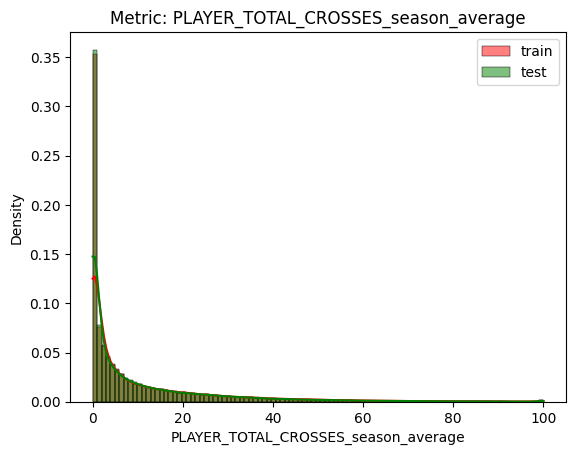

PLAYER_PASSES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0003360630060524304, 'estimated_typical_loss_value': 0.0001676512293537897, 'loss_value_normalized': 2.0045364853412493}


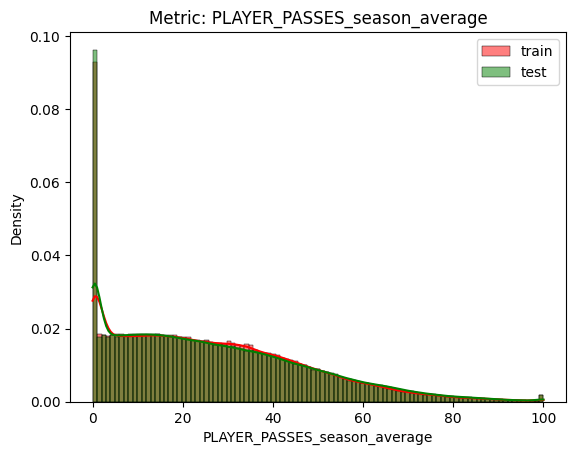

PLAYER_ACCURATE_PASSES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00032794976892926793, 'estimated_typical_loss_value': 0.00016290590056708, 'loss_value_normalized': 2.0131239432532437}


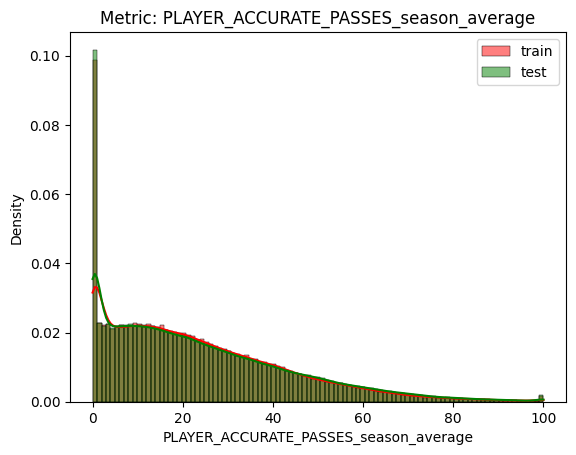

PLAYER_FOULS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00032463641809781375, 'estimated_typical_loss_value': 0.00015034486694727236, 'loss_value_normalized': 2.1592783624012113}


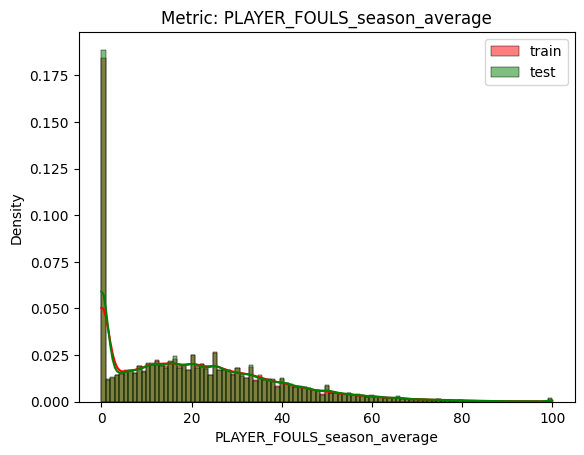

PLAYER_SHOTS_TOTAL_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00031613679721189666, 'estimated_typical_loss_value': 0.0001456998245798745, 'loss_value_normalized': 2.1697815911789564}


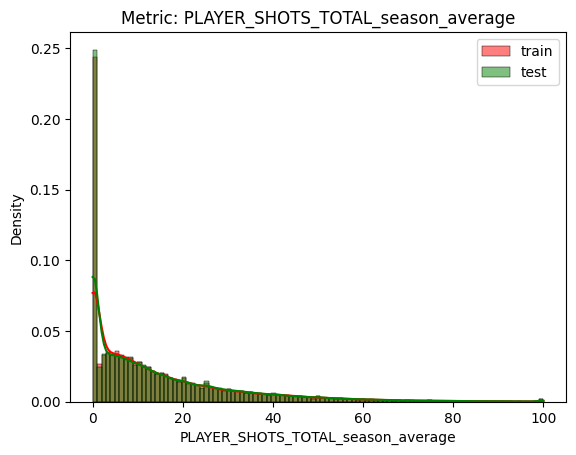

PLAYER_INTERCEPTIONS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0003220250370667283, 'estimated_typical_loss_value': 0.00014701861007456528, 'loss_value_normalized': 2.190369211781532}


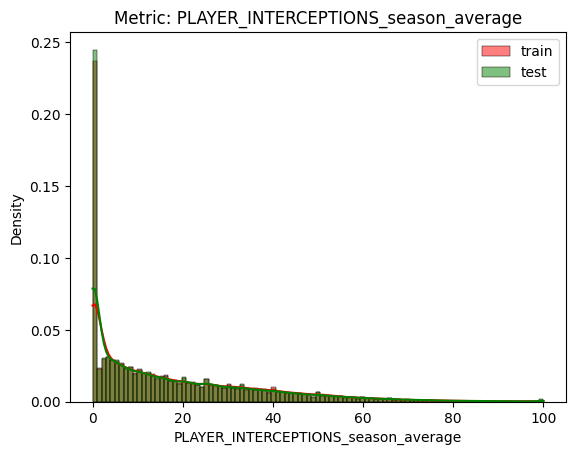

PLAYER_PENALTIES_MISSES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 7.10070609549899e-05, 'estimated_typical_loss_value': 3.078007116874216e-05, 'loss_value_normalized': 2.306916724305267}


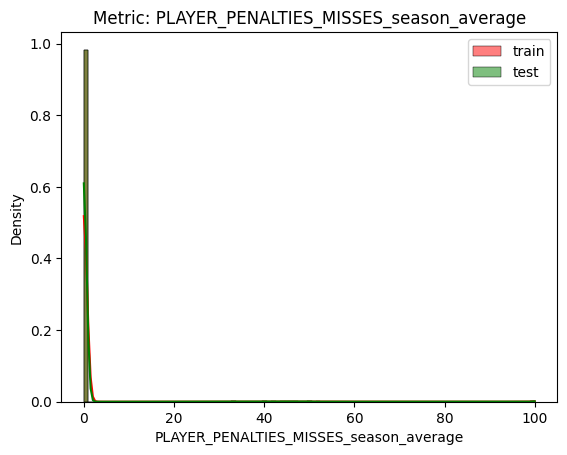

PLAYER_TACKLES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00034227101160605526, 'estimated_typical_loss_value': 0.0001479681102629741, 'loss_value_normalized': 2.3131403854333588}


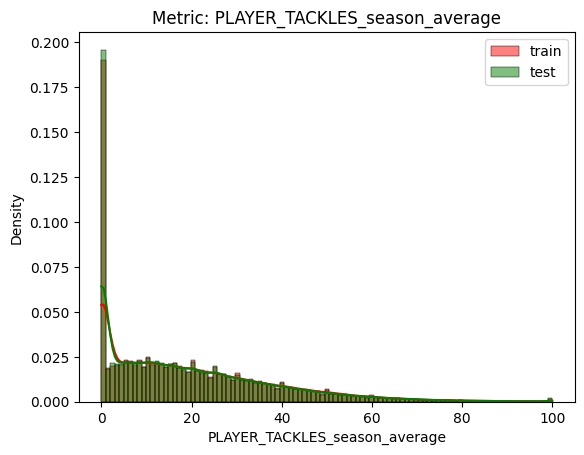

PLAYER_TOTAL_DUELS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000387351316024555, 'estimated_typical_loss_value': 0.00016500819499531275, 'loss_value_normalized': 2.3474671426775924}


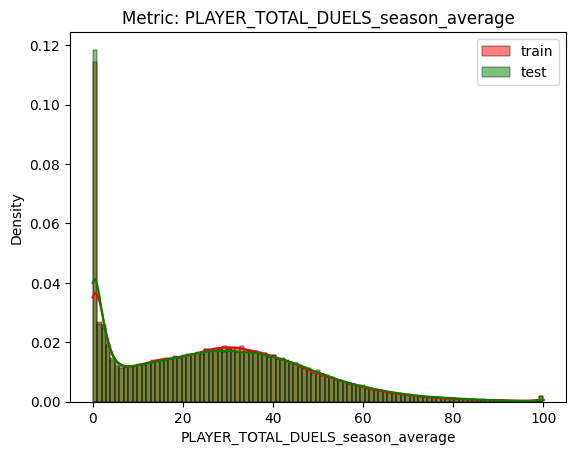

PLAYER_KEY_PASSES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00033257789803889934, 'estimated_typical_loss_value': 0.00013821050295736805, 'loss_value_normalized': 2.406314215794084}


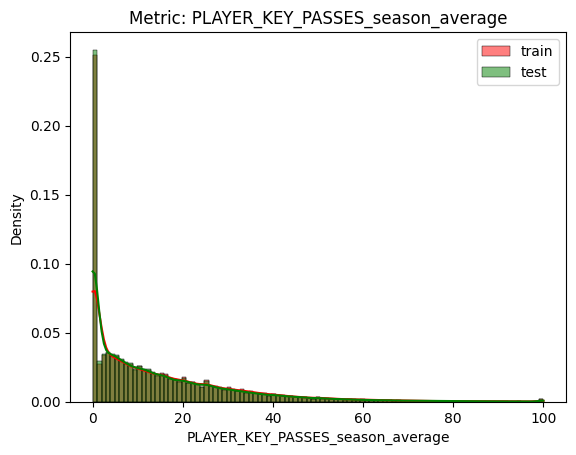

PLAYER_ACCURATE_CROSSES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0002764554738070484, 'estimated_typical_loss_value': 0.00010958715001034161, 'loss_value_normalized': 2.522699730583371}


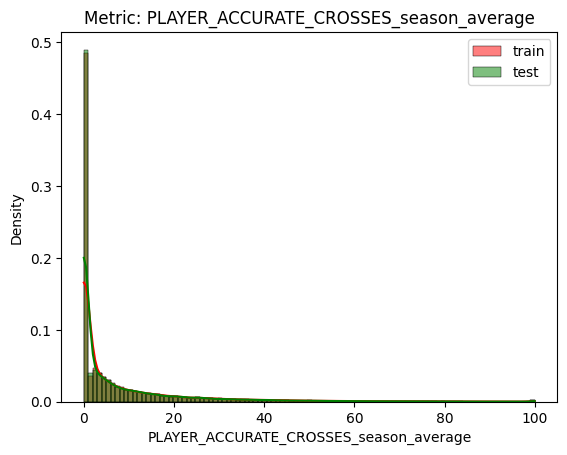

PLAYER_CLEARANCES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0003764414072489632, 'estimated_typical_loss_value': 0.00014573190600142077, 'loss_value_normalized': 2.5831090636028575}


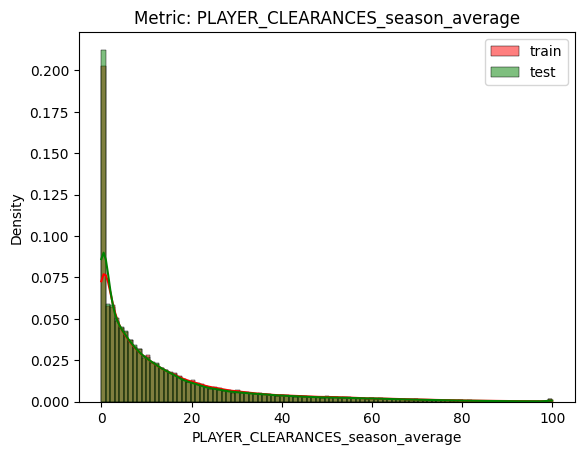

PLAYER_AERIALS_WON_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00037853693896263953, 'estimated_typical_loss_value': 0.00014314965146798662, 'loss_value_normalized': 2.644344118760965}


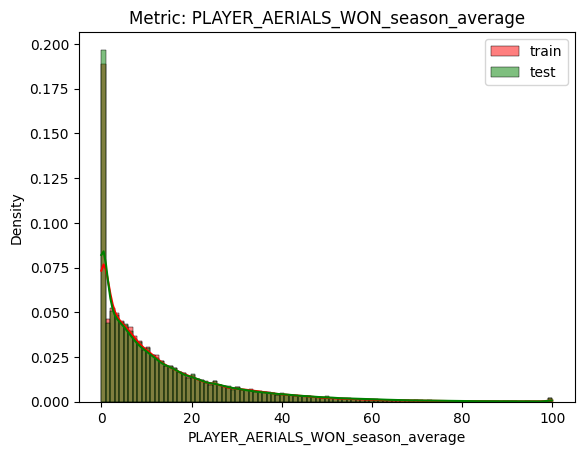

PLAYER_SUCCESSFUL_DRIBBLES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000346705264501803, 'estimated_typical_loss_value': 0.0001300788429578006, 'loss_value_normalized': 2.6653470819515763}


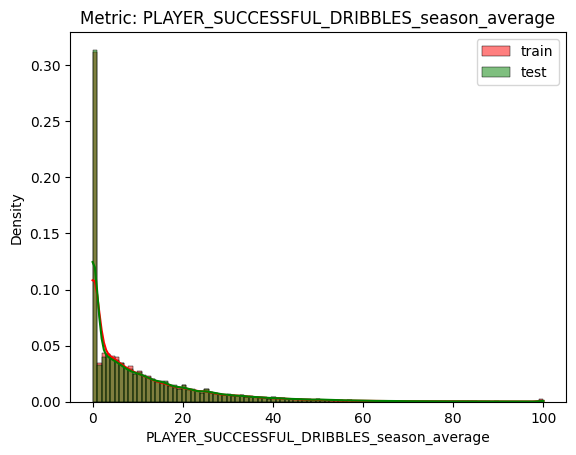

PLAYER_SHOTS_ON_TARGET_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00035132780476828507, 'estimated_typical_loss_value': 0.00012400580696723466, 'loss_value_normalized': 2.8331560703482648}


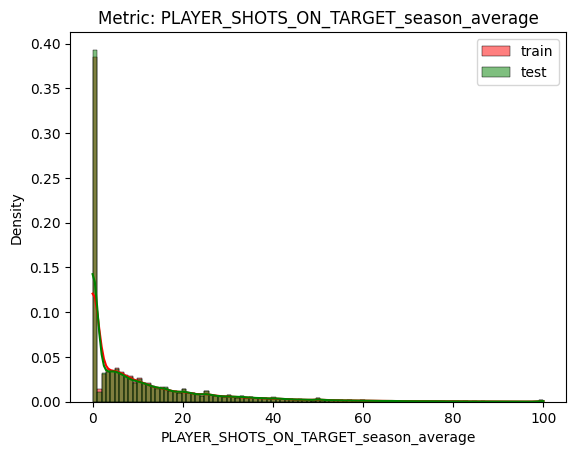

PLAYER_DRIBBLED_PAST_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00042559982276351674, 'estimated_typical_loss_value': 0.0001482577437414826, 'loss_value_normalized': 2.870675163551651}


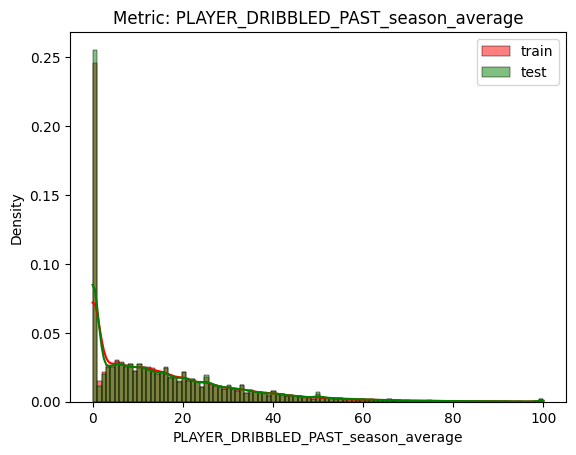

PLAYER_OFFSIDES_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00030092155011542235, 'estimated_typical_loss_value': 0.00010043079506117298, 'loss_value_normalized': 2.9963075561780026}


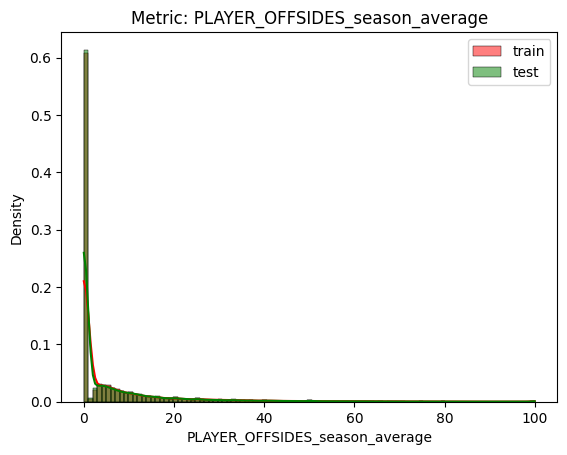

PLAYER_SHOTS_BLOCKED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000449002167453319, 'estimated_typical_loss_value': 0.00013780917544792954, 'loss_value_normalized': 3.25814421277231}


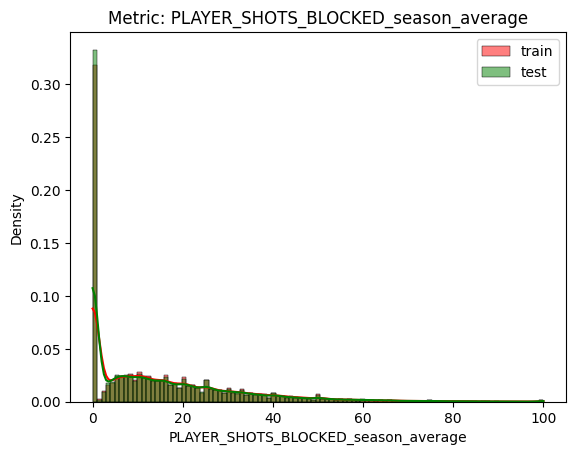

PLAYER_ACCURATE_PASSES_PERCENTAGE_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000573576943483893, 'estimated_typical_loss_value': 0.00015788665055963425, 'loss_value_normalized': 3.63284002447341}


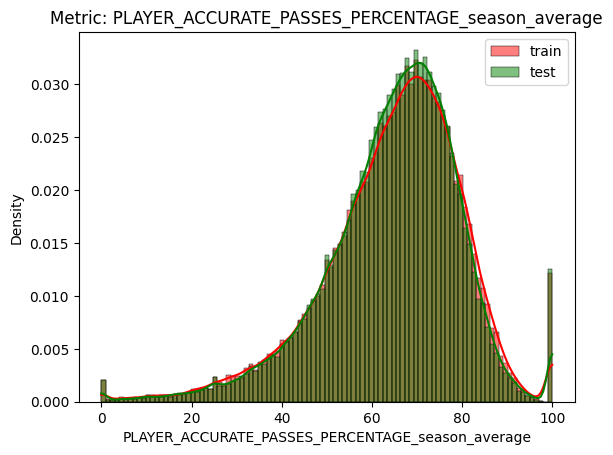

PLAYER_DRIBBLED_ATTEMPTS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00047352989175301446, 'estimated_typical_loss_value': 0.00012806654639568838, 'loss_value_normalized': 3.6975299567236224}


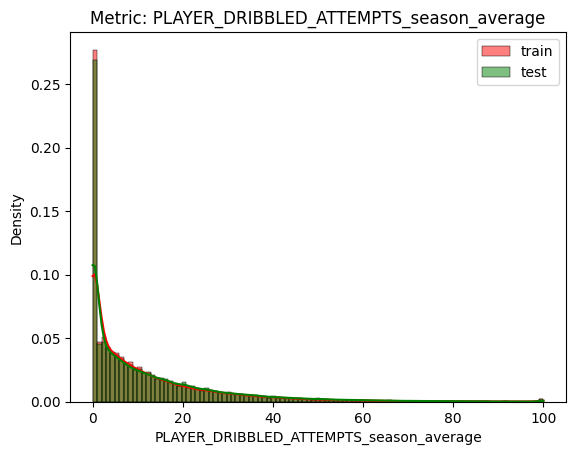

PLAYER_OWN_GOALS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00011793956961457157, 'estimated_typical_loss_value': 3.184050508666776e-05, 'loss_value_normalized': 3.704073452752252}


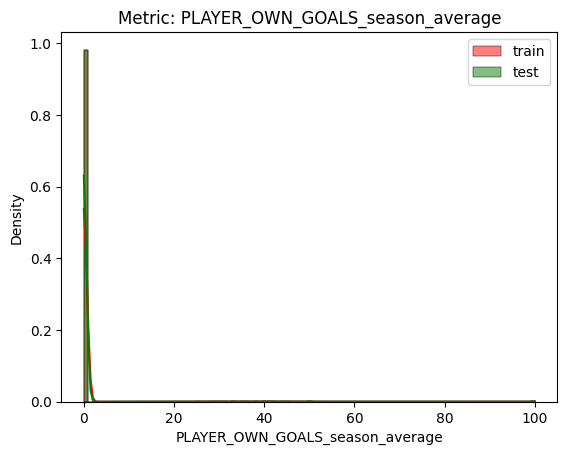

PLAYER_PENALTIES_SCORED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00016649461977816715, 'estimated_typical_loss_value': 4.3473020283607444e-05, 'loss_value_normalized': 3.829837878554244}


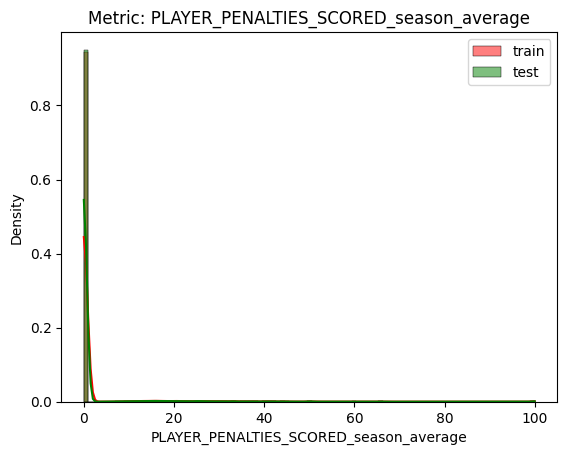

PLAYER_YELLOWCARDS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0004750857731712787, 'estimated_typical_loss_value': 0.00012084159412188079, 'loss_value_normalized': 3.931475553783529}


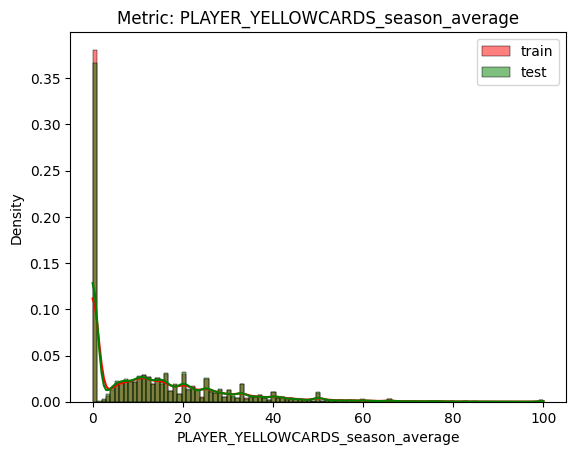

PLAYER_CLEARANCE_OFFLINE_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00016157628784388637, 'estimated_typical_loss_value': 4.064577422815288e-05, 'loss_value_normalized': 3.975229674210253}


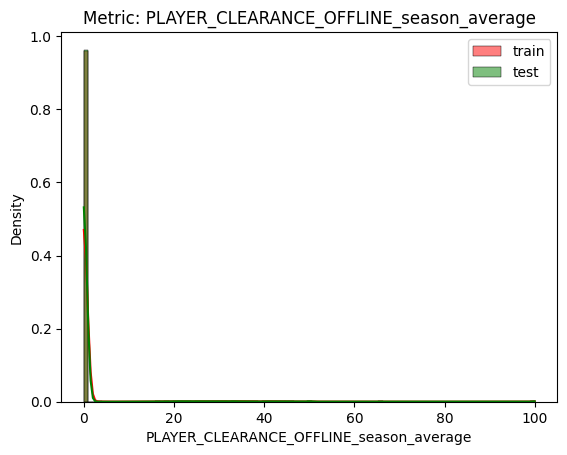

PLAYER_STARTING_LINEUP_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000631294858055819, 'estimated_typical_loss_value': 0.00015549795681951125, 'loss_value_normalized': 4.059827350578443}


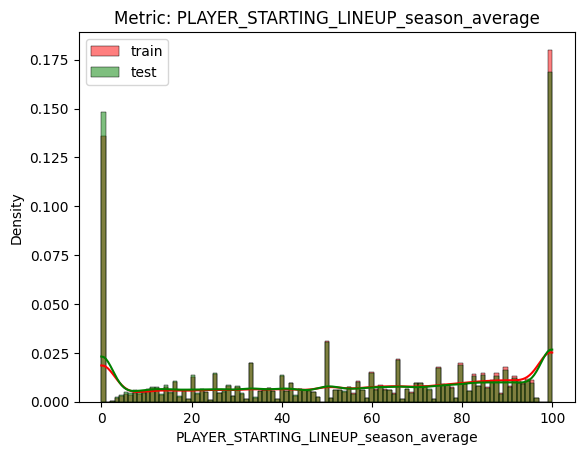

PLAYER_RATING_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000715972700630845, 'estimated_typical_loss_value': 0.00017394088602363129, 'loss_value_normalized': 4.1161840496354625}


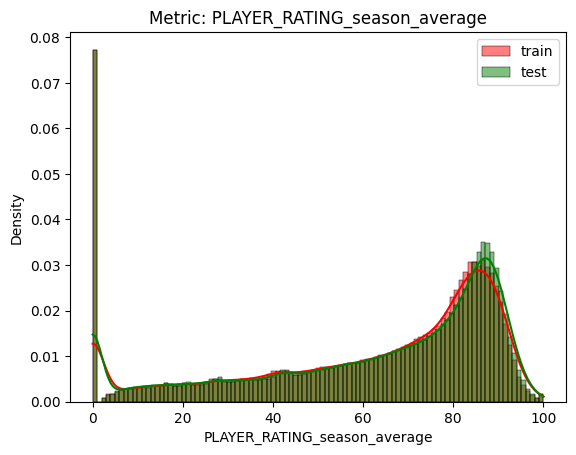

PLAYER_PENALTIES_COMMITTED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00023870810454246585, 'estimated_typical_loss_value': 5.7460357128813435e-05, 'loss_value_normalized': 4.154309448624075}


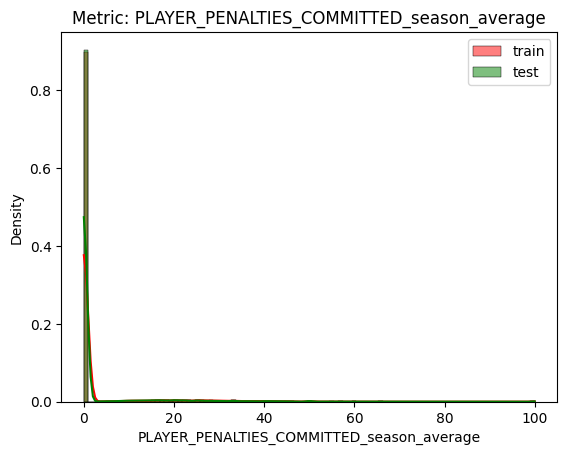

PLAYER_DISPOSSESSED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0005965504261106814, 'estimated_typical_loss_value': 0.00013412630611367053, 'loss_value_normalized': 4.44767654753814}


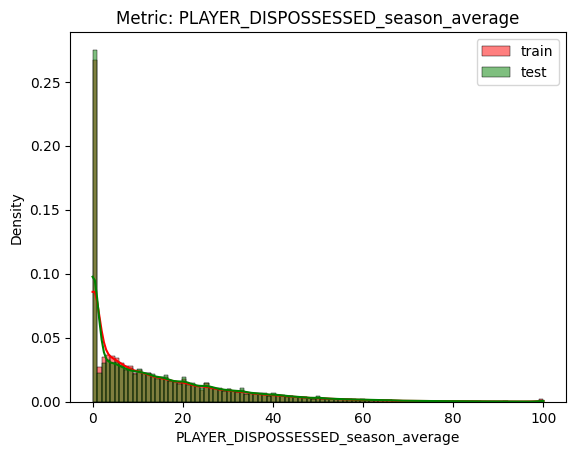

PLAYER_MINUTES_PLAYED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0008281761011089263, 'estimated_typical_loss_value': 0.0001830000795331892, 'loss_value_normalized': 4.525550498232008}


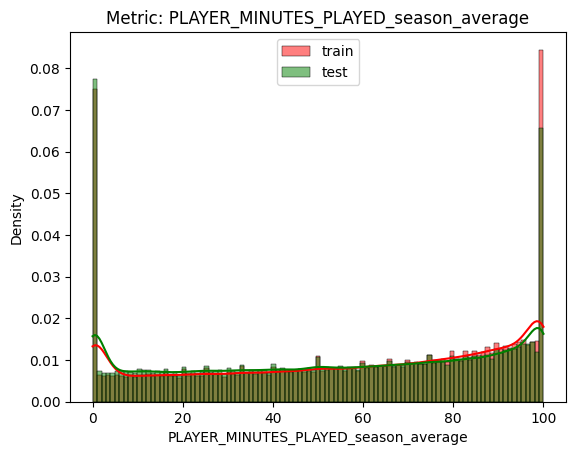

PLAYER_GOALS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0004634537127766813, 'estimated_typical_loss_value': 9.968237665820635e-05, 'loss_value_normalized': 4.6493044037739155}


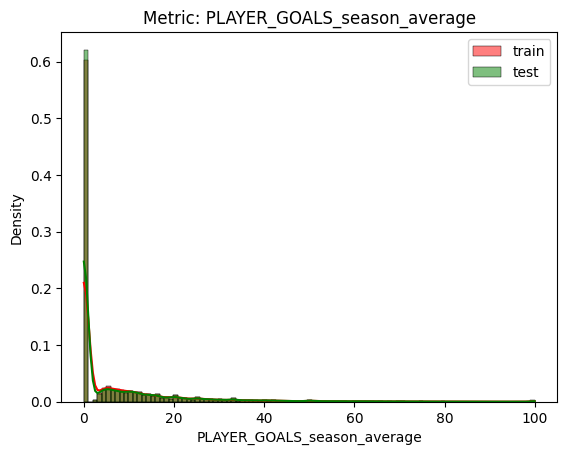

PLAYER_REDCARDS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00021596063546431752, 'estimated_typical_loss_value': 4.5272821211029235e-05, 'loss_value_normalized': 4.7702049416493315}


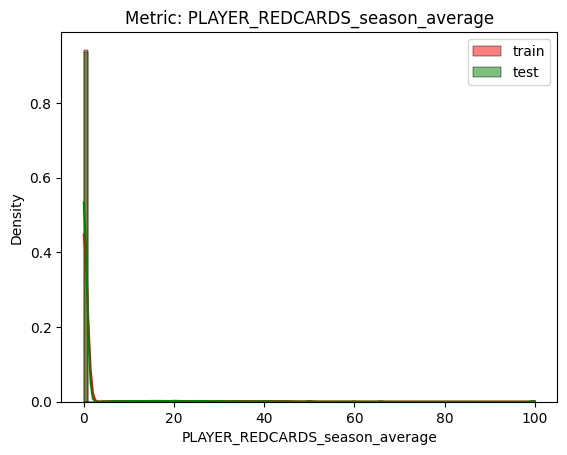

PLAYER_PENALTIES_WON_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0002513971901350799, 'estimated_typical_loss_value': 5.119863232342537e-05, 'loss_value_normalized': 4.910232534062547}


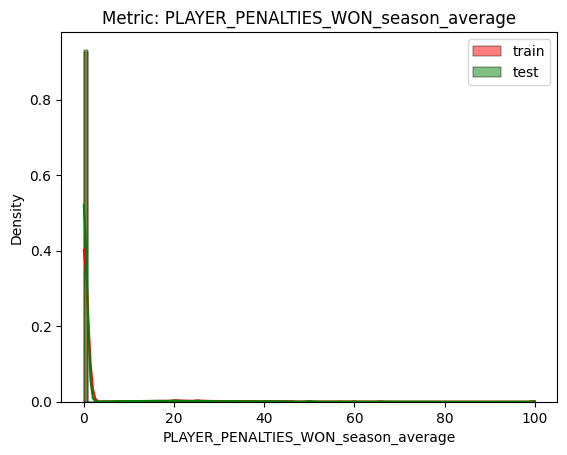

PLAYER_HIT_WOODWORK_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.00034411548269927414, 'estimated_typical_loss_value': 6.846125924955243e-05, 'loss_value_normalized': 5.0264264267153065}


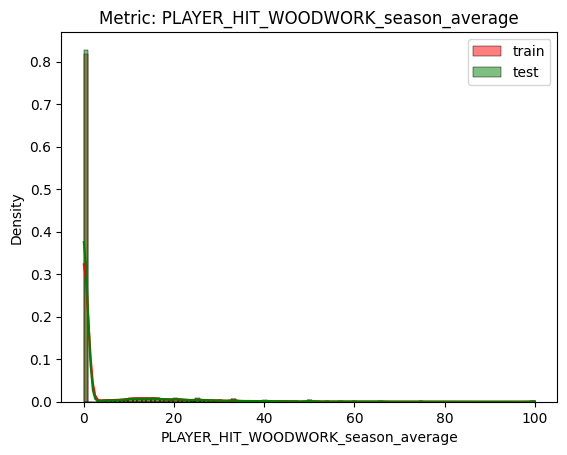

PLAYER_BIG_CHANCES_CREATED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0007035230125301567, 'estimated_typical_loss_value': 0.00010890239397190113, 'loss_value_normalized': 6.460124400114147}


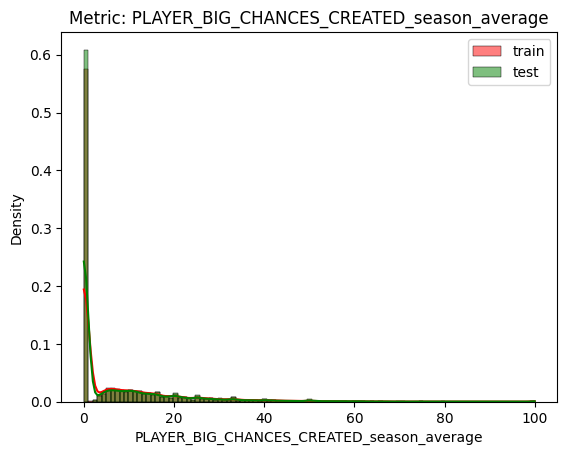

PLAYER_ASSISTS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.000657890853013773, 'estimated_typical_loss_value': 9.735988733995634e-05, 'loss_value_normalized': 6.757309103235529}


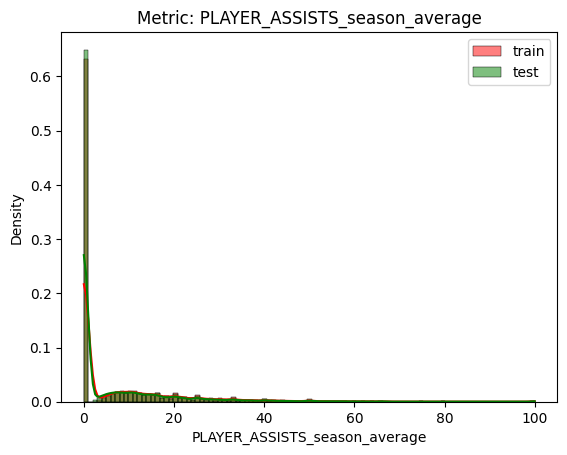

PLAYER_BIG_CHANCES_MISSED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0006578943336548321, 'estimated_typical_loss_value': 9.446710713613929e-05, 'loss_value_normalized': 6.964268871970167}


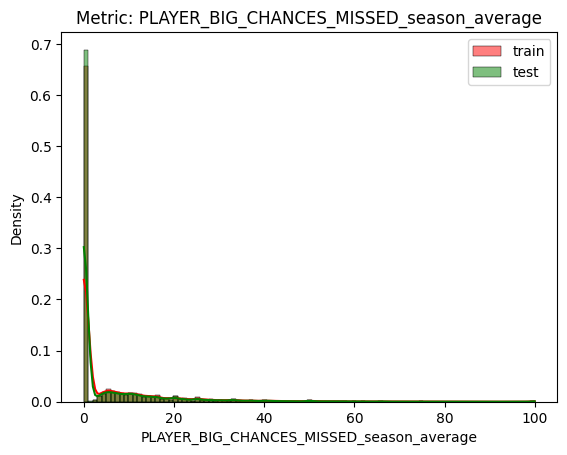

PLAYER_GOALS_CONCEDED_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0010261286738614316, 'estimated_typical_loss_value': 0.00014536115268632327, 'loss_value_normalized': 7.0591671495214445}


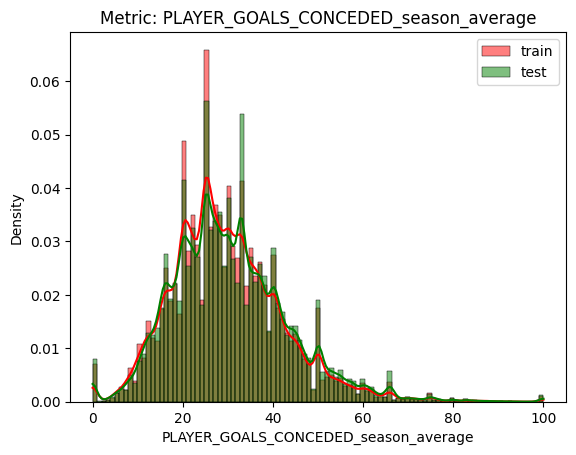

PLAYER_ERROR_LEAD_TO_GOAL_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0003332430629015705, 'estimated_typical_loss_value': 4.5729204015195405e-05, 'loss_value_normalized': 7.2873138747225665}


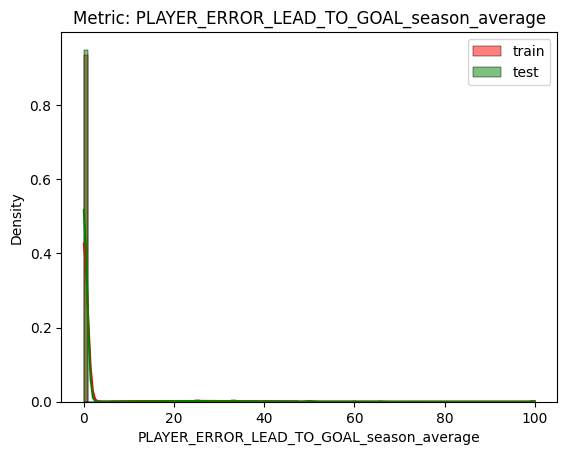

PLAYER_BLOCKED_SHOTS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0013479392661491284, 'estimated_typical_loss_value': 0.00011537809712667743, 'loss_value_normalized': 11.682800286319397}


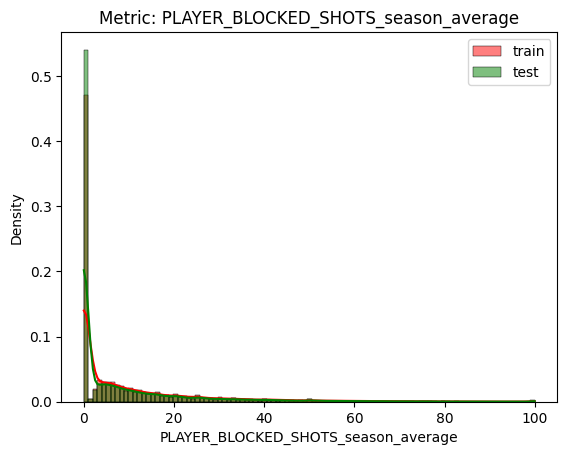

PLAYER_DUELS_LOST_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0019679643555201355, 'estimated_typical_loss_value': 0.00015804040482519135, 'loss_value_normalized': 12.452286221957845}


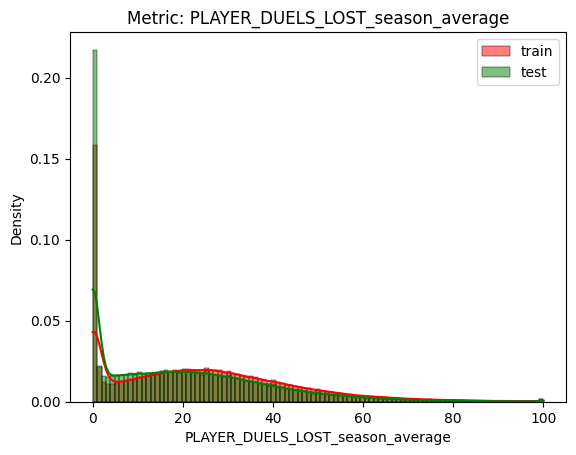

PLAYER_LONG_BALLS_WON_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.014073307837256169, 'estimated_typical_loss_value': 0.00015781615172813398, 'loss_value_normalized': 89.17533270916472}


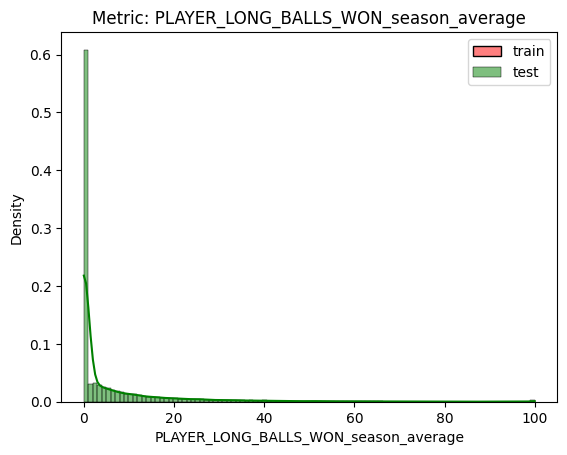

PLAYER_LONG_BALLS_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.0143132240421329, 'estimated_typical_loss_value': 0.00015485298902583608, 'loss_value_normalized': 92.43104787421521}


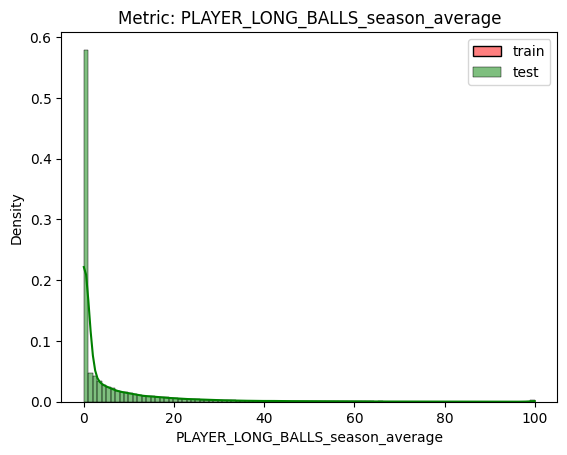

PLAYER_SHOTS_OFF_TARGET_season_average train-distribution vs test-distribution difference (l1_loss normalized): {'loss_value': 0.014768374489462801, 'estimated_typical_loss_value': 0.00014532224950368516, 'loss_value_normalized': 101.62500608047449}


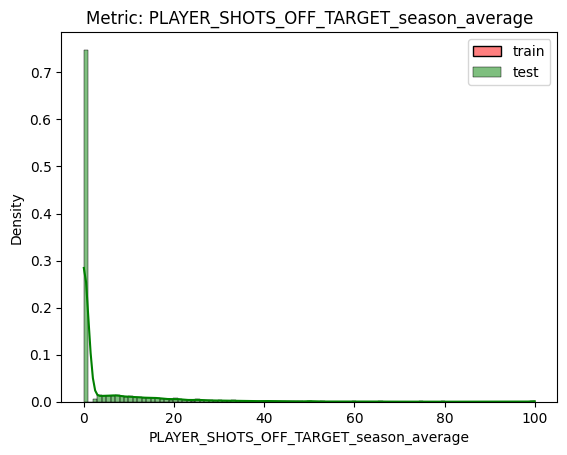

In [45]:
for column_name, loss_name_to_loss_values in sorted(metric_names_to_loss_name_to_loss_values.items(), key = lambda x : x[1][LOSS_NAME][LOSS_STATISTIC], reverse=False):
    print(f"{column_name} train-distribution vs test-distribution difference ({LOSS_NAME} normalized): {loss_name_to_loss_values[LOSS_NAME]}")
    fig, ax = plt.subplots()
    ax.set_title(f"Metric: {column_name}")
    sns.histplot(df_playersfeatures_train[column_name], kde=True, label="train", color='red', stat='density', bins=101)
    sns.histplot(df_playersfeatures_test[column_name], kde=True, label="test", color='green', stat='density', bins=101)
    plt.legend()
    plt.show()

# Conclusion

Visually, the distributions look the same.
Numerically, some results should make us carefull with some metrics.